# Système de Recommandation de livres

## Imports

In [1]:
import pandas as pd
import numpy as np
import os
import json
import psycopg2
import re
import ast
import nltk
import gensim
import glob
import joblib
import torch
import pickle
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

from scipy import sparse
from gensim.parsing.preprocessing import remove_stopwords

from sentence_transformers import SentenceTransformer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from surprise import SVD, NMF, Dataset, Reader, BaselineOnly, AlgoBase , SVDpp,  dump, accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection.search import RandomizedSearchCV

from sklearn.neighbors import NearestNeighbors
from joblib import dump, load
from sklearn.preprocessing import normalize


# les imports qui suivent sont d'un dossier package créé pour éviter de faire toutes les opérations dans le notebook


# utils : contient les fonctions globales
# reco_collab_initial contient les fonctions pour la recommandation collaborative sur ce dataset précis

%load_ext autoreload
%autoreload 2

import sys
import os

# Ajouter le dossier parent du notebook au path
sys.path.append(os.path.abspath('..'))


from recommandation_de_livres.config import RAW_DATA_DIR, PROCESSED_DATA_DIR, INTERIM_DATA_DIR, MODELS_DIR

2025-08-28 23:15:35.580 | INFO     | recommandation_de_livres.config:<module>:11 - PROJ_ROOT path is: D:\TER\reco_books


In [2]:
# Choix du dosser du dataset
DIR = "recommender"

## Fonctions utilitaires

In [3]:
def save_df_to_csv(df, filepath, index = False):
    """ Sauvegarde le dataFrame en csv dans le chemin filepath.
    """
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    df.to_csv(filepath, index=index, encoding="utf-8")


def save_df_to_pickle(df, filepath):
    """ Sauvegarde le dataFrame en pkl dans le chemin filepath.
    """
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    df.to_pickle(filepath)

def save_df_to_parquet(df, filepath):
    """ Sauvegarde le dataFrame en parquet dans le chemin filepath.
    """
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    df.to_parquet(filepath, engine='pyarrow', index=False, compression='snappy')

## Chargement des données

In [4]:
books = pd.read_csv(RAW_DATA_DIR / DIR / "books.csv")
ratings = pd.read_csv(RAW_DATA_DIR / DIR / "ratings.csv")
users = pd.read_csv(RAW_DATA_DIR / DIR / "users.csv")

In [5]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [6]:
books.shape

(271360, 8)

In [7]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [8]:
ratings.shape

(1149780, 3)

In [9]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [10]:
users.shape

(278858, 3)

## Uniformisation des colonnes

On va uniformiser les colonnes pour pouvoir faire en sorte que nos fonctions ne dépendent pas de noms de colonnes précis. Pour ça on va définir plusieurs fonctions 

In [8]:
def rename_ratings_columns(ratings, user_col, rating_col, item_col=None):
    """
    Renomme les colonnes pour uniformiser les datasets utilisateurs.
    Si item_col est None, sera défini plus tard via unify_book_ids.
    
    Args:
        ratings (pd.DataFrame) : DataFrame avec les utilisateurs, livres et leurs notes.
        user_col (str) : colonne utilisateur à renommer.
        item_col (str) : colonne livre à renommer.
        rating_col (str) : colonne note à renommer.

    Returns:
        pd.DataFrame: DataFrame avec les colonnes renommées.
    """
    ratings = ratings.copy()
    ratings.rename(columns={user_col: "user_id", rating_col: "rating"}, inplace=True)
    if item_col is not None:
        ratings.rename(columns={item_col: "item_id"}, inplace=True)
    return ratings

def unify_book_ids(df):
    """
    Définit la colonne 'item_id' à partir de 'book_id' ou 'ISBN' si item_id n'existe pas.
    """
    df = df.copy()
    if 'item_id' not in df.columns:
        if 'book_id' in df.columns:
            df['item_id'] = df['book_id']
        elif 'ISBN' in df.columns:
            df['item_id'] = df['ISBN']
        else:
            raise ValueError("Le dataset n'a ni 'book_id' ni 'ISBN'.")
    return df

def rename_books_columns(books, book_id_col=None, isbn_col=None, 
                         language_col=None, title_col=None, 
                         author_col=None,
                         cat_col=None, desc_col=None,
                         publisher_col=None, 
                         year_col=None, image_col=None):
    """
    Renomme les colonnes d'un dataset de livres pour uniformiser.
    Les colonnes peuvent être None si elles n'existent pas.
    Retourne un dataframe avec les noms uniformisés.

    Args:
        books (pd.DataFrame) : le dataFrame dont les colonnes sont à modifier
        book_id_col (str) : colonne qui servira en tant qu'item_id
        isbn_col (str) : colonne isbn qui pourrait servir en tant qu'item_id si book_id_col est None
        title_col (str) : colonne qui servira en tant que title
        author_col (str) : colonne qui servira en tant qu'authors
        publisher_col (str) : colonne qui servira en tant que publisher
        year_col (str) : colonne qui servira en tant que year
        image_col (str) : colonne qui servira en tant qu'image_url

    Returns:
        books (pd.DataFrame) : DataFrame avec les colonnes renommées.
    """
    books = books.copy()
    
    # Définir item_id à partir de book_id ou ISBN
    if book_id_col is not None and book_id_col in books.columns:
        books['item_id'] = books[book_id_col]
    elif isbn_col is not None and isbn_col in books.columns:
        books['item_id'] = books[isbn_col]

    # Mapping des autres colonnes
    rename_map = {}
    if isbn_col is not None: rename_map[isbn_col] = "isbn"
    if title_col is not None: rename_map[title_col] = "title"
    if author_col is not None: rename_map[author_col] = "authors"
    if desc_col is not None: rename_map[desc_col] = "description"
    if cat_col is not None: rename_map[cat_col] = "categories"
    if language_col is not None: rename_map[language_col] = "language"
    if publisher_col is not None: rename_map[publisher_col] = "publisher"
    if year_col is not None: rename_map[year_col] = "year"
    if image_col is not None: rename_map[image_col] = "image_url"

    books.rename(columns=rename_map, inplace=True)
    
    return books


In [9]:
books.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')

In [10]:
books = rename_books_columns(books, isbn_col='ISBN', title_col='Book-Title', 
                             author_col='Book-Author', year_col='Year-Of-Publication', 
                             publisher_col='Publisher', image_col='Image-URL-L')

books.columns

Index(['isbn', 'title', 'authors', 'year', 'publisher', 'Image-URL-S',
       'Image-URL-M', 'image_url', 'item_id'],
      dtype='object')

In [11]:
books.drop(columns=['Image-URL-S', 'Image-URL-M'], inplace=True)

In [12]:
books.head()

,isbn,title,authors,year,publisher,image_url,item_id
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,0195153448
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,0002005018
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,0060973129
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,0374157065
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,0393045218


In [13]:
ratings.columns

Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')

In [14]:
ratings = rename_ratings_columns(ratings, user_col='User-ID', rating_col='Book-Rating', item_col='ISBN')

ratings.columns

Index(['user_id', 'item_id', 'rating'], dtype='object')

In [15]:
ratings.head()

,user_id,item_id,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


Maintenant que les colonnes sont uniformisées, on va pouvoir travailer plus facilement sur le dataset. D'abord, faisons une exploration des données.

## Exploration des données

In [15]:
# Séparer ratings > 0 et ratings = 0
ratings_positive = ratings[ratings["rating"] > 0]
ratings_zero = ratings[ratings["rating"] == 0]

On sépare les notes positives des notes nulles. Dans beaucoup de cas les notes nulles signifient qu'il y a eu interaction implicite entre l'utilisateur et le livre (clic etc). On veut avoir des données correctes pour les statistiques descriptives.

In [16]:
# Nombre de ratings > 0 par livre
count_positive = ratings_positive.groupby("item_id")["rating"].count().reset_index()
count_positive.rename(columns={"rating": "num_ratings_positive"}, inplace=True)

# Moyenne des ratings > 0
avg_rating = ratings_positive.groupby("item_id")["rating"].mean().reset_index()
avg_rating.rename(columns={"rating": "avg_rating"}, inplace=True)

# Nombre d'interactions = 0
count_zero = ratings_zero.groupby("item_id")["rating"].count().reset_index()
count_zero.rename(columns={"rating": "num_ratings_zero"}, inplace=True)

On calcule le nombre de types de notes et la moyenne des notes positives.

In [17]:
# Fusionner toutes les stats
book_stats = books[["item_id", "title"]].merge(count_positive, on="item_id", how="left") \
                                    .merge(avg_rating, on="item_id", how="left") \
                                    .merge(count_zero, on="item_id", how="left")

# Remplacer les NaN par 0
book_stats[["num_ratings_positive", "avg_rating", "num_ratings_zero"]] = \
book_stats[["num_ratings_positive", "avg_rating", "num_ratings_zero"]].fillna(0)

On va afficher les livres avec le plus de notes positives.

In [18]:
# Trier par nombre de ratings positifs
top_books = book_stats.sort_values("num_ratings_positive", ascending=False).head(10)

top_books

,item_id,title,num_ratings_positive,avg_rating,num_ratings_zero
408,0316666343,The Lovely Bones: A Novel,707.0,8.185290,588.0
26,0971880107,Wild Animus,581.0,4.390706,1921.0
748,0385504209,The Da Vinci Code,487.0,8.435318,396.0
522,0312195516,The Red Tent (Bestselling Backlist),383.0,8.182768,340.0
1105,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,320.0,7.887500,412.0
2143,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,313.0,8.939297,258.0
356,0142001740,The Secret Life of Bees,307.0,8.452769,308.0
706,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,295.0,8.142373,290.0
305,044023722X,A Painted House,281.0,7.338078,366.0
231,0452282152,Girl with a Pearl Earring,278.0,7.982014,248.0


Text(0, 0.5, 'Titre du livre')

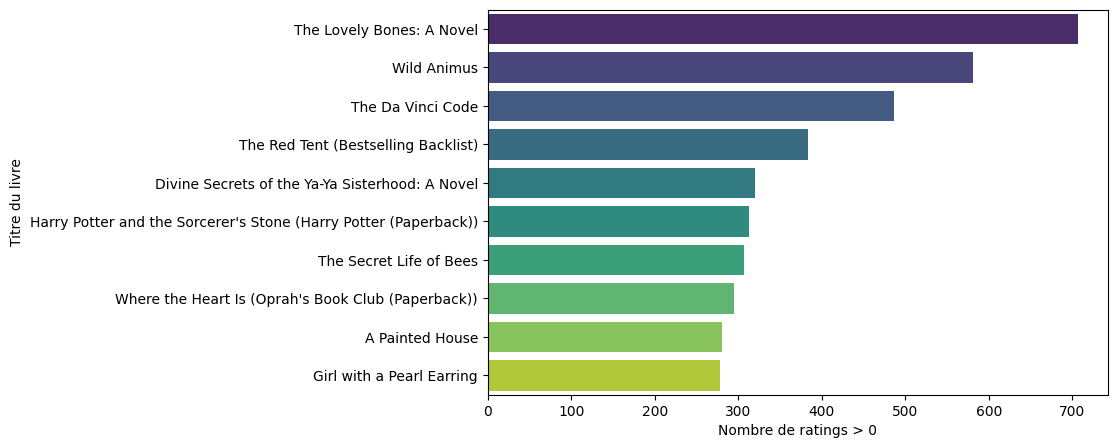

In [19]:
# Barplot horizontal du nombre de ratings positifs
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(
    x="num_ratings_positive",
    y="title",
    data=top_books,
    hue='title',
    palette="viridis",
    orient="h"
)
ax.set_xlabel("Nombre de ratings > 0")
ax.set_ylabel("Titre du livre")

On affiche les auteurs avec le plus de livres dans le dataset.

In [20]:
# Compter le nombre de livres par auteur
author_counts = books["authors"].value_counts().reset_index()
author_counts.columns = ["author", "num_books"]

# Prendre le top 10
top_authors = author_counts.head(10)
top_authors

,author,num_books
0,Agatha Christie,632
1,William Shakespeare,567
2,Stephen King,524
3,Ann M. Martin,423
4,Carolyn Keene,373
5,Francine Pascal,372
6,Isaac Asimov,330
7,Nora Roberts,315
8,Barbara Cartland,307
9,Charles Dickens,302


Text(0, 0.5, 'Auteur')

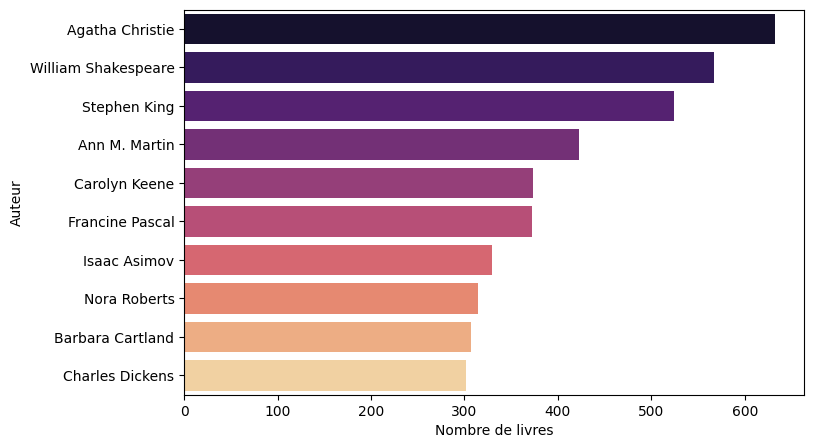

In [21]:
# Barplot horizontal
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(
x="num_books",
y="author",
data=top_authors,
hue='author',
palette="magma",
orient="h"
)
ax.set_xlabel("Nombre de livres")
ax.set_ylabel("Auteur")

Text(0.5, 1.0, 'Répartition des notes dans le dataset')

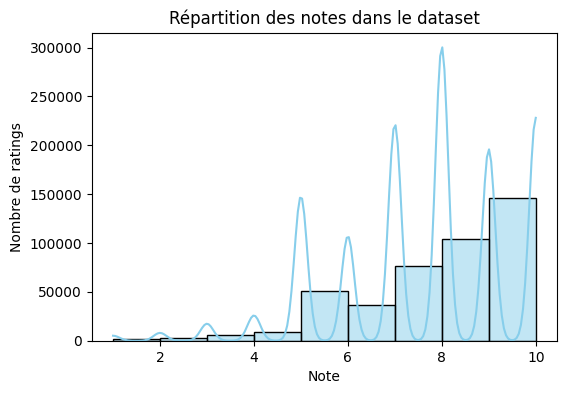

In [22]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(ratings_positive["rating"], bins=9, kde=True, color="skyblue", ax=ax)
ax.set_xlabel("Note")
ax.set_ylabel("Nombre de ratings")
ax.set_title("Répartition des notes dans le dataset")

In [23]:
# Proportion des types de notes

counts = pd.Series({
"0 (implicite)": len(ratings_zero),
">0 (réel)": len(ratings_positive)
})
counts_df = counts.reset_index()
counts_df.columns = ["Type de note", "Nombre"]
counts_df["Proportion"] = round(counts_df["Nombre"] / counts_df["Nombre"].sum(), 2)

(0.0, 1.0)

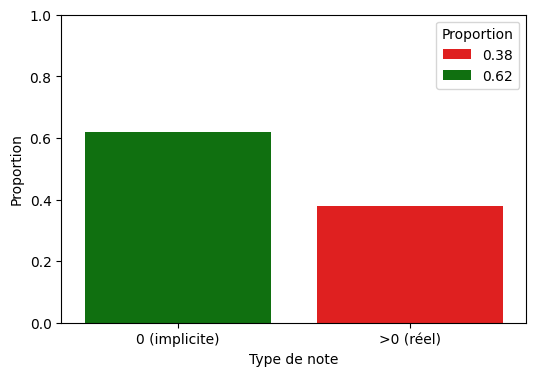

In [24]:

fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(
    x="Type de note",
    y="Proportion",
    data=counts_df,
    hue='Proportion',
    palette=["red", "green"],
    ax=ax
)
ax.set_ylabel("Proportion")
ax.set_ylim(0, 1)

On remarque que plus de la moitié des "notes" du dataset sont en fait des interactions implicites. On pourra peut-être les utiliser pour la recommandation, mais pour l'instant on restera sur les interactions explicites (notes supérieurs à 0).

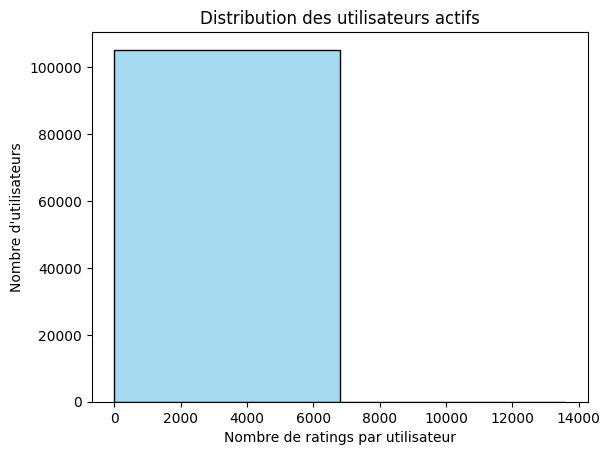

In [25]:
user_counts = ratings.groupby("user_id").size()
sns.histplot(user_counts, bins=2, color="skyblue")
plt.xlabel("Nombre de ratings par utilisateur")
plt.ylabel("Nombre d'utilisateurs")
plt.title("Distribution des utilisateurs actifs")
plt.show()


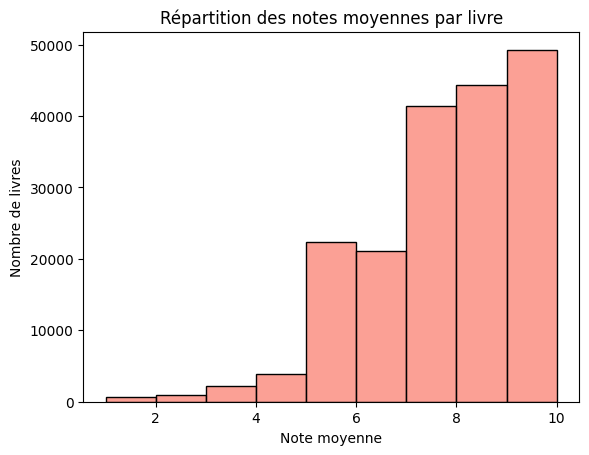

In [26]:
book_means = ratings_positive.groupby("item_id")["rating"].mean()
sns.histplot(book_means, bins=9, color="salmon")
plt.xlabel("Note moyenne")
plt.ylabel("Nombre de livres")
plt.title("Répartition des notes moyennes par livre")
plt.show()


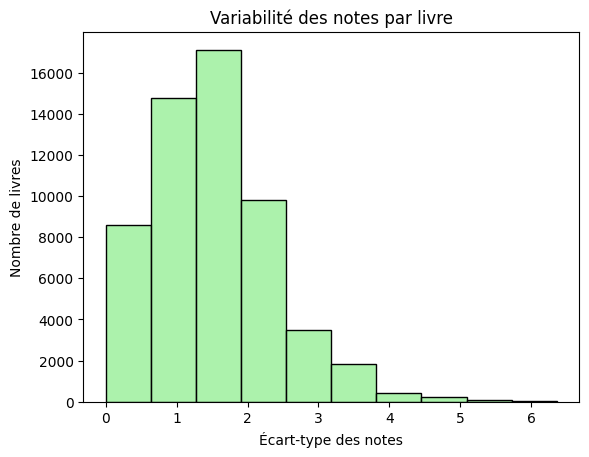

In [27]:
book_std = ratings_positive.groupby("item_id")["rating"].std()
sns.histplot(book_std.dropna(), bins=10, color="lightgreen")
plt.xlabel("Écart-type des notes")
plt.ylabel("Nombre de livres")
plt.title("Variabilité des notes par livre")
plt.show()


## Création des datasets

### Partie collaborative

In [28]:
def preprocess_collaborative(ratings, min_ratings = 10, min_users_interaction = 10):
    """ Fonction permettant de faire le prétraitement des données du dataset ratings.
        Args:
            ratings (pd.DataFrame) : DataFrame des notes
            min_rating_book (int) : nombre de notes minimal que le livre a reçu
            min_users_interaction (int) : nombre de notes minimal que l'utilisateur a donné
        
        Returns:
            ratings_explicit_filtered (pd.DataFrame) : DataFrame des interactions explicites filtré
            ratings_implicit_filtered (pd.DataFrame) : DataFrame des interactions implicites filtré
    """
    
    # On sépare le dataset pour garder que les interactions explicites
    ratings_explicit = ratings[ratings['rating'] != 0].copy()
    ratings_implicit = ratings[ratings['rating'] == 0].copy()

    # On les trie pour regrouper les notes d'un même utilisateur
    ratings_explicit.sort_values(by='user_id', inplace=True)
    ratings_explicit.reset_index(drop=True, inplace=True)

    ratings_implicit.sort_values(by='user_id', inplace=True)
    ratings_implicit.reset_index(drop=True, inplace=True)

    # Filtrage par le nombre d'interaction faite par un utilisateur
    mask_rating = ratings_explicit['user_id'].value_counts() > min_users_interaction
    user_indexes = mask_rating[mask_rating].index

    ratings_tmp = ratings_explicit[ratings_explicit['user_id'].isin(user_indexes)].reset_index(drop=True).copy()

    # Filtrage par le nombre d’interactions qu'un livre a reçu
    mask_books = ratings_tmp['item_id'].value_counts() > min_ratings
    book_indexes = mask_books[mask_books].index

    ratings_explicit_filtered = ratings_tmp[ratings_tmp['item_id'].isin(book_indexes)].reset_index(drop=True).copy()

    # Filtrage de ratings implicit pour garder le dataset cohérent
    ratings_implicit_filtered = ratings_implicit[
    (ratings_implicit['user_id'].isin(ratings_tmp['user_id'])) &
    (ratings_implicit['item_id'].isin(ratings_tmp['item_id']))
    ].reset_index(drop=True).copy()

    return ratings_explicit_filtered, ratings_implicit_filtered


def add_book_metadata(ratings, books):
    """ Fonction ajoutant les données des livres du dataset book.
        Args:
            ratings (pd.DataFrame) : DataFrame des notes
            books (pd.DataFrame) : DataFrame des livres
        Returns:
            ratings_books (pd.DataFrame) : DataFrame des notes avec les données des livres

    """

    books_subset = books[['item_id', 'isbn', 'title', 'authors', 'publisher', 'image_url']]

    ratings_books = ratings.merge(books_subset, on='item_id')

    # Supprimer les doublons user-livre
    ratings_books = ratings_books.drop_duplicates(subset=['user_id', 'item_id'])

    return ratings_books

def build_collaborative_dataset(books, ratings, min_ratings=0, min_users_interaction=0):
    """ Fonction permettant de créer le dataset collaboratif. Un index est aussi créé en se basant sur les user_id.
        Args:
            books (pd.DataFrame) : DataFrame des livres
            ratings (pd.DataFrame) : DataFrame des notes
            min_ratings (int) : nombre de notes minimal que le livre a reçu
            min_users_interaction (int) : nombre de notes minimal que l'utilisateur a donné
        Returns:
            collaborative_dataset (pd.DataFrame) : DataFrame du dataset collaboratif complet
    """

    ratings_explicit, _ = preprocess_collaborative(ratings, min_ratings=min_ratings, min_users_interaction=min_users_interaction)

    collaborative_dataset = add_book_metadata(ratings_explicit, books)

    cats = collaborative_dataset['user_id'].astype("category")
    collaborative_dataset['user_index'] = cats.cat.codes + 1  

    return collaborative_dataset


In [29]:
collaborative_dataset = build_collaborative_dataset(books, ratings, min_ratings=10, min_users_interaction=10)

collaborative_dataset.head()

,user_id,item_id,rating,isbn,title,authors,publisher,image_url,user_index
0,242,0553278223,10,0553278223,The Martian Chronicles,RAY BRADBURY,Spectra,http://images.amazon.com/images/P/0553278223.0...,1
1,243,0446364800,9,0446364800,The General's Daughter,Nelson DeMille,Warner Books,http://images.amazon.com/images/P/0446364800.0...,2
2,243,155874262X,5,155874262X,Chicken Soup for the Soul (Chicken Soup for th...,Jack Canfield,Health Communications,http://images.amazon.com/images/P/155874262X.0...,2
3,243,0449006522,6,0449006522,Manhattan Hunt Club,JOHN SAUL,Ballantine Books,http://images.amazon.com/images/P/0449006522.0...,2
4,243,0446606383,6,0446606383,The Midnight Club,James Patterson,Warner Vision,http://images.amazon.com/images/P/0446606383.0...,2


In [30]:
collaborative_dataset.shape

(66265, 9)

Notre dataset collaboratif est fini, sauvegardons le et passons au dataset pour la recommandation basée sur le contenu.

In [43]:
DIR_OUTPUT = Path(PROCESSED_DATA_DIR / DIR / "collaborative_dataset.csv")
DIR_OUTPUT.parent.mkdir(parents=True, exist_ok=True) # Sert à vérifier si le dossier existe, le crée sinon

DIR_OUTPUT_PARQUET = Path(PROCESSED_DATA_DIR / DIR / "collaborative_dataset.parquet")
DIR_OUTPUT_PARQUET.parent.mkdir(parents=True, exist_ok=True) # Sert à vérifier si le dossier existe, le crée sinon

save_df_to_csv(collaborative_dataset, DIR_OUTPUT)
save_df_to_parquet(collaborative_dataset, DIR_OUTPUT_PARQUET)

### Partie basée sur le contenu

#### Extraction d'informations supplémentaires

Cette partie va demander plus de travail que la précédente. Déjà notre dataset n'a ni genres ni description, on va donc les extraire depuis une base de données externes créés à partir des données d'openlibrary. 
- Données : https://openlibrary.org/developers/dumps
- Création de la base : https://github.com/LibrariesHacked/openlibrary-search

In [212]:
# Mettre son username te password de postgresql ici 

user = "XXX"
password = "XXX"

In [ ]:
def get_key_books_list(isbn_list):
    """ Renvoie une liste de key de la table 'editions' correspondant aux isbn donnés.
        Args:
            isbn_list (str[]) : liste d'isbn
        Returns:
            keys_books (str[]) : liste des editions_keys de nos livres
    """
    conn = psycopg2.connect(
        dbname='openlibrary',
        user=user,
        password=password,
        host='localhost',
        port='5432'
    )
    conn.autocommit = True
    cur = conn.cursor()

    sql = """
        SELECT e.key
        FROM editions e
        JOIN edition_isbns ei ON ei.edition_key = e.key
        WHERE ei.isbn = %s
    """

    key_books = []
    for isbn in tqdm(isbn_list, desc='Récupération des clés dans la databse'):
        cur.execute(sql, (isbn,))
        results = cur.fetchall()
        key_books.extend([r[0] for r in results])

    cur.close()
    conn.close()

    return key_books

def update_editions_work_key(keys_list):
    """ Met à jour la base de données avec les clés données. C'est pour éviter de mettre entièrement la base de données à jour.
        Args:
            keys_list (str[]) : liste des clés des données à mettre à jour
        Returns:
            None
    """
    conn = psycopg2.connect(
        dbname='openlibrary',
        user=user,
        password=password,
        host='localhost',
        port='5432'
    )
    conn.autocommit = True
    cur = conn.cursor()

    query = """
        UPDATE editions
        SET work_key = data->'works'->0->>'key'
        WHERE key = %s;
    """

    for key in tqdm(keys_list, desc='Mise à jour de la database avec les clés trouvées'):
        cur.execute(query, (key,))

    cur.close()
    conn.close()

def split_subject_words(subject):
    """ Permet de séparer les mots tout en ignorant la ponctuation et les espaces. 
        On met aussi en minuscule les mots pour éciter la casse.
        Arguments :
            subject (str) : liste de genres retournés lors de la requête sql
    """
    return re.findall(r'\b\w+\b', subject.lower())

def get_infos_by_isbn_list(isbn_list):
    """ Permet de récupérer les informations des livres depuis la base de données.
        Args:
            isbn_list (str[]) : Liste d'isbn
        Returns:
            subjects_final (str[][]) : Liste de listes avec les sujets extraits de chaque livre
            desc_final (str[][]) : Liste de listes avec les descriptions extraites de chaque livre
    """
    conn = psycopg2.connect(
        dbname='openlibrary',
        user='XXX', 
        password='XXX', 
        host='localhost',
        port='5432'
    )
    conn.autocommit = True
    cur = conn.cursor()

    # Requête sql permettant de récupérer les genres et descriptions d'un livre via son isbn
    sql = """
        select
        e.data->>'subjects' "Subjects",
        w.data->'description'->>'value' "WorkDescription"
    from editions e
    join edition_isbns ei
        on ei.edition_key = e.key
    join works w
        on w.key = e.work_key
    where ei.isbn = %s
    """

    # Comme on peut avoir plusieurs résultats pour un même isbn, 
    # la requête renverra plusieurs fois des subjects et descriptions (assez souvent identiques)
    # On traite de ce cas juste après
    
    subjects_final= [] # liste de listes qui contiendra les genres recueillis de chaque livre
    desc_final=[] # liste des descriptions des livres
    for isbn in tqdm(isbn_list):
        cur.execute(sql, (isbn,))
        results = cur.fetchall()

        # On crée ici des sets pour éviter les doublons lors de l'ajout des genres ou descriptions
        all_words = set()
        description_set = set()
        for r in results:
            
            if r[0]:
                subjects_list = json.loads(r[0]) 
                for subject in subjects_list:
                    words = split_subject_words(subject) # On sépare les mots des listes de genres qu'on obtient 
                                                         # pour comparer avec les suivants et ne pas ajouter de doublon
                    for w in words:
                        all_words.add(w)

            
            if r[1]:
                description_set.add(r[1])

        subjects_words = list(all_words)
        descriptions = list(description_set)
        subjects_final.append(subjects_words)
        desc_final.append(descriptions)

    cur.close()
    conn.close()

    return subjects_final, desc_final

In [110]:
def list_to_str_desc(lst):
    """ Transforme une liste contenant une phrase en un str.
        Args:
            lst (str[]) : liste contenant la phrase
    """
    if isinstance(lst, list):
        return ' '.join(str(x) for x in lst)
    return str(lst)

def list_to_str_cate(lst):
    """ Transforme une liste de mots en un str avec des mots séparés par une virgule.
        Args:
            lst (str[]) : liste de mots 
    """
    if isinstance(lst, list):
        return ', '.join(str(x) for x in lst)
    return str(lst)

def get_infos(books, update=True): 
    """ Fonction qui permete d'ajouter les colonnes descriptions et categories
        avec les informations extraites de la base de données.
        Args:
            books (pd.DataFrame) : DataFrame de livres
            update (Bool) : Booléen qui sert à déclencher la mise à jour de la base de données (nécessaire la première fois)
        Returns:
            books_df (pd.DataFrame) : DataFrame mis à jour
    """
    books_df = books.copy()
    isbn_list = books_df['isbn'] # Récupération des isbn
    if update :
        keys=get_key_books_list(isbn_list) # Récupération des clés
        update_editions_work_key(keys) # Mise à jour de la base de données
    categories, descriptions = get_infos_by_isbn_list(isbn_list) # Récupération des informations

    # Ajout des informations dans des colonnes
    books_df['description'] = descriptions 
    books_df['categories'] = categories 

    # Traitement des textes obtenus pour les avoir en str
    books_df['description'] = books_df['description'].apply(list_to_str_desc)
    books_df['categories'] = books_df['categories'].apply(list_to_str_cate)

    return books_df

In [42]:
isbn_list = books['isbn']
isbn_list[:10]

0    0195153448
1    0002005018
2    0060973129
3    0374157065
4    0393045218
5    0399135782
6    0425176428
7    0671870432
8    0679425608
9    074322678X
Name: isbn, dtype: object

In [43]:
books_desc = get_infos(books, update=True)

Récupération des clés dans la databse: 100%|██████████| 271360/271360 [01:33<00:00, 2895.57it/s]
Mise à jour de la database avec les clés trouvées: 100%|██████████| 367546/367546 [02:05<00:00, 2940.02it/s]
100%|██████████| 271360/271360 [04:07<00:00, 1098.04it/s]


In [44]:
books_desc.head()

,isbn,title,authors,year,publisher,Image-URL-S,Image-URL-M,image_url,item_id,description,categories
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,0195153448,An excellent primer on classical mythology for...,"classical, mythology"
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,0002005018,"E-book extras: ""Hero of the Humdrum"": A profil...","y, teachers, sisters, new, women, n, ontario, ..."
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,0060973129,,"france, 1945, 1939, world, campaigns, war, nor..."
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,0374157065,"The fascinating, true story of the world's dea...","influenza, century, history, 20th"
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,0393045218,"In the museums of Urumchi, the wind-swept regi...","uygur, antiquities, mummies, bronze, textile, ..."


In [45]:
books_desc.shape

(271360, 11)

In [46]:
# Sauvegarde du dataset pour ne pas refaire l'opération
DIR_OUTPUT = Path(INTERIM_DATA_DIR / DIR / "books_desc.csv")
DIR_OUTPUT.parent.mkdir(parents=True, exist_ok=True) # Sert à vérifier si le dossier existe, le crée sinon

save_df_to_csv(books_desc, DIR_OUTPUT)

#### Filtrage du dataset

On a nos descriptions et categories, on va pouvoir commencer à filtrer nos livres. D'abord on ne veut que les livres en anglais pour que l'entrainement des modèles NLP plus tard n'ait pas de soucis. Pour cela, on va utiliser le module Lingua.
- Lien github : https://github.com/pemistahl/lingua-py

In [48]:
!pip install lingua-language-detector


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
DIR_OUTPUT = Path(INTERIM_DATA_DIR / DIR / "books_desc.csv")
DIR_OUTPUT.parent.mkdir(parents=True, exist_ok=True) # Sert à vérifier si le dossier existe, le crée sinon

books_desc = pd.read_csv(DIR_OUTPUT)

In [68]:
from lingua import Language, LanguageDetectorBuilder

languages = [Language.ENGLISH, Language.FRENCH, Language.GERMAN, Language.SPANISH]
detector = LanguageDetectorBuilder.from_languages(*languages).build()

def detect_lang(text):
    """ Détecte la langue du texte donnée
        Args:
            text (str) : texte servant à déterminer la langue
    """
    # On gère une exception au cas où
    try:
        lang=detector.detect_language_of(text)
        return lang.iso_code_639_3.name.lower()
    
    except Exception as e:
        return ""
    
def add_language_column(books, title_col="title", desc_col="description", lang_col="language"):
    """ Ajoute une colonne de langue uniquement pour les lignes où elle est NaN.
        Args:
            books (pd.DataFrame) :  DataFrame de livres
            title_col (str) : Colonne des titres
            desc_col (str) : Colonne des descriptions
            lang_col (str) : Colonne des langues
        Returns:
            books (pd.DataFrame) : DataFrame des livres avec les langues ajoutées
    """
    books = books.copy()
    if lang_col not in books.columns:
        books[lang_col] = None
    
    tqdm.pandas(desc="Détection de la langue")
    mask = books[lang_col].isna()

    books.loc[mask, lang_col] = (
        (books.loc[mask, title_col].fillna('') + ' ' + books.loc[mask, desc_col].fillna(''))
        .progress_apply(detect_lang)
    )
    return books

In [69]:
books_desc = add_language_column(books_desc)

Détection de la langue: 100%|██████████| 271360/271360 [00:40<00:00, 6761.60it/s]


In [70]:
books_desc[['isbn', 'title', 'language']].head()

,isbn,title,language
0,0195153448,Classical Mythology,eng
1,0002005018,Clara Callan,eng
2,0060973129,Decision in Normandy,eng
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,eng
4,0393045218,The Mummies of Urumchi,eng


In [82]:
# Sauvegarde du dataset pour ne pas refaire l'opération
DIR_OUTPUT = Path(INTERIM_DATA_DIR / DIR / "books_desc_lang.csv")
DIR_OUTPUT.parent.mkdir(parents=True, exist_ok=True) # Sert à vérifier si le dossier existe, le crée sinon
save_df_to_csv(books_desc, DIR_OUTPUT)

On a maintenant nos langues. On peut filtrer entièrement nos livres pour garder ceux qui nous intéressent. On définit aussi différentes fonctions de nettoyage de texte pour plsuieurs cas.

In [ ]:
import re
import html
import gensim
from gensim.parsing.preprocessing import remove_stopwords

def nettoyage_balises(text):
    """ On enlève les balises hmtl pour avoir un bon affichage.
        Args:
            text (str) : texte à nettoyer
        Returns:
            text (str) : texte nettoyé
    """

    if not isinstance(text, str):
        return ""
    text = re.sub(r'<.*?>', '', text)
    text = html.unescape(text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def nettoyage_avance(text):
    """ On nettoie les texte de sorte à pouvoir les comparer.
        Args:
            text (str) : texte à nettoyer
        Returns:
            text (str) : texte nettoyé
    """
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r'\(.*?\)', '', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = " ".join(gensim.utils.simple_preprocess(text))
    text = remove_stopwords(text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text


In [73]:
def filter_books_basic(books, title_col="title", desc_col="description", lang_col=None, allowed_langs=None):
    """ Filtre les livres vides ou non anglais.
        Args:
            books (pd.DataFrame) :  DataFrame de livres
            title_col (str) : Colonne des titres
            desc_col (str) : Colonne des descriptions
            lang_col (str) : Colonne des langues
            allowed_langs: liste de codes de langue (ex: ['en', 'eng', 'en-US'])
    """
    books = books.copy()
    
    # Supprime les titres NaN ou vides
    books = books[books[title_col].notna() & (books[title_col].str.strip() != "")]
    
    # Supprime les descriptions NaN ou vides
    books = books[books[desc_col].notna() & (books[desc_col].str.strip() != "")]
    
    # Filtre sur langue si la colonne est fournie
    if lang_col and allowed_langs:
        books = books[books[lang_col].isin(allowed_langs) | books[lang_col].isnull()].copy()
    
    return books

def remove_duplicates(books, title_col="title"):
    """ Supprime les doublons par titre nettoyé.
        Args:
            books (pd.DataFrame) :  DataFrame de livres
            title_col (str) : Colonne des titres
        Returns:
            books (pd.DataFrame) : DataFrame des livres sans doublon
    """
    tqdm.pandas(desc="Nettoyage des textes")
    books['title_clean'] = books[title_col].progress_apply(nettoyage_avance)
    books = books.drop_duplicates(subset='title_clean').reset_index(drop=True)
    return books

In [88]:
allowed_langs=['en', 'eng', 'en-US', 'en-GB', 'en-CA']

In [89]:
books_desc = filter_books_basic(books_desc)

In [90]:
books_desc.shape

(58934, 13)

In [91]:
books_desc=remove_duplicates(books_desc)

Nettoyage des textes: 100%|██████████| 58934/58934 [00:00<00:00, 104941.42it/s]


In [92]:
books_desc.shape

(58934, 13)

In [93]:
books_desc.head()

,isbn,title,authors,year,publisher,Image-URL-S,Image-URL-M,image_url,item_id,description,categories,language,title_clean
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,0195153448,An excellent primer on classical mythology for...,"classical, mythology",eng,classical mythology
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,0002005018,"E-book extras: ""Hero of the Humdrum"": A profil...","y, teachers, sisters, new, women, n, ontario, ...",eng,clara callan
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,0374157065,"The fascinating, true story of the world's dea...","influenza, century, history, 20th",eng,flu story great influenza pandemic search viru...
3,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,0393045218,"In the museums of Urumchi, the wind-swept regi...","uygur, antiquities, mummies, bronze, textile, ...",eng,mummies urumchi
4,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...,0425176428,With its in-depth reflections on the monumenta...,"wars, and, battles, histories, imaginary",eng,world foremost military historians imagine


#### Construction du dataset en une fonction

In [ ]:
def build_content_dataset(books, title_col="title", desc_col=None,
                          lang_col="language", add_language=False, get_description=False, allowed_langs=None, update_db=False):
    """Construit le dataset de contenu à partir d'un DataFrame de livres.
    Args:
        books (pd.DataFrame) : DataFrame contenant les informations sur les livres.
        title_col (str) : Nom de la colonne contenant les titres des livres.
        desc_col (str, optionnel) : Nom de la colonne contenant les descriptions des livres. 
                                     Si None et `get_description=True`, les descriptions sont récupérées automatiquement.
        lang_col (str) : Nom de la colonne contenant le code de langue.
        add_language (bool) : Si True, ajoute la langue manquante en se basant sur le titre/description.
        get_description (bool) : Si True, récupère les descriptions manquantes depuis une source externe.
        allowed_langs (list, optionnel) : Liste des codes de langues autorisées (ex: ['en', 'eng', 'en-US']).
        update_db (bool) : Si True, met à jour la base de données lors de la récupération des descriptions.

    Returns:
        pd.DataFrame : DataFrame nettoyé, filtré et prêt pour une utilisation en filtrage basé sur le contenu.
    """

    if desc_col is None and get_description:
        books = get_infos(books, update=update_db)
        desc_col="description"
        catego_col="categories"

    # --- Nettoyage des balises html et du bruit ---
    books['title'] = books['title'].apply(nettoyage_balises)
    books['authors'] = books['authors'].apply(nettoyage_balises)
    books['categories'] = books['categories'].apply(nettoyage_balises)
    books['publisher'] = books['publisher'].apply(nettoyage_balises)
    books['description'] = books['description'].apply(nettoyage_balises)

    # --- Ajout de la langue pour les lignes où elle est manquante ---
    if add_language:
        books = add_language_column(books, title_col=title_col, desc_col=desc_col, lang_col=lang_col)

    # --- Filtrage de base (NaN sur titre/description et langues autorisées) ---
    books = filter_books_basic(books, title_col=title_col, desc_col=desc_col,
                               lang_col=lang_col, allowed_langs=allowed_langs)

    # --- Suppression des doublons sur titre nettoyé ---
    books = remove_duplicates(books, title_col=title_col)

    return books

In [ ]:
allowed_langs=['en', 'eng', 'en-US', 'en-GB', 'en-CA']

In [111]:
content_dataset = build_content_dataset(books, title_col='title', 
                                        lang_col="language", add_language=True, 
                                        get_description=True, allowed_langs=allowed_langs,
                                        update_db=False)

Nettoyage des textes: 100%|██████████| 77457/77457 [00:00<00:00, 108880.87it/s]


In [112]:
content_dataset.shape

(57468, 13)

In [113]:
content_dataset.head()

,isbn,title,authors,year,publisher,Image-URL-S,Image-URL-M,image_url,item_id,description,categories,language,title_clean
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,0195153448,An excellent primer on classical mythology for...,"classical, mythology",eng,classical mythology
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,0002005018,"E-book extras: ""Hero of the Humdrum"": A profil...","y, teachers, sisters, new, women, n, ontario, ...",eng,clara callan
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,0374157065,"The fascinating, true story of the world's dea...","influenza, century, history, 20th",eng,flu story great influenza pandemic search viru...
3,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton & Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,0393045218,"In the museums of Urumchi, the wind-swept regi...","uygur, antiquities, mummies, bronze, textile, ...",eng,mummies urumchi
4,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...,0425176428,With its in-depth reflections on the monumenta...,"wars, and, battles, histories, imaginary",eng,world foremost military historians imagine


In [114]:
DIR_OUTPUT = Path(PROCESSED_DATA_DIR / DIR / "content_dataset.csv")
DIR_OUTPUT.parent.mkdir(parents=True, exist_ok=True) # Sert à vérifier si le dossier existe, le crée sinon

DIR_OUTPUT_PARQUET = Path(PROCESSED_DATA_DIR / DIR / "content_dataset.parquet")
DIR_OUTPUT_PARQUET.parent.mkdir(parents=True, exist_ok=True) # Sert à vérifier si le dossier existe, le crée sinon

save_df_to_csv(content_dataset, DIR_OUTPUT)
save_df_to_parquet(content_dataset, DIR_OUTPUT_PARQUET)

Nos deux datasets sont finis. On peut commencer le prétraitement des textes pour la partie NLP.

## Préparation des features

In [5]:
DIR_INPUT_PARQUET = Path(PROCESSED_DATA_DIR / DIR / "content_dataset.parquet")
content_df = pd.read_parquet(DIR_INPUT_PARQUET)

Avant de prétraiter les textes, on va combiner les colonnes qui nous intéressent, ici on prend titre, categories et description.

In [7]:
def combine_text(row, cols):
    parts = [str(row.get(col, '')) for col in cols] # fusion des textes des colonnes correspondantes
    return ' '.join(parts)

In [8]:
tqdm.pandas()

cols_to_combine = ['title', 'categories', 'description']
content_df['text_combined'] = content_df.progress_apply(lambda row: combine_text(row, cols_to_combine), axis=1)

100%|██████████| 57468/57468 [00:00<00:00, 126759.43it/s]


In [9]:
content_df['text_combined']

0        Classical Mythology classical, mythology An ex...
1        Clara Callan y, teachers, sisters, new, women,...
2        Flu: The Story of the Great Influenza Pandemic...
3        The Mummies of Urumchi uygur, antiquities, mum...
4        What If?: The World's Foremost Military Histor...
                               ...                        
57463    The Unified Modeling Language Reference Manual...
57464    Driving to Detroit: Memoirs of a Fast Woman ro...
57465    Der Mossad.  The first time the Mossad came ca...
57466    Slow Food(The Case For Taste) food, und, habit...
57467    Anti Death League modern, general, fiction Ami...
Name: text_combined, Length: 57468, dtype: object

Maintenant on va tokeniser nos textes.

In [10]:
tqdm.pandas(desc='Tokenisation des textes')
content_df['text_clean'] = content_df['text_combined'].progress_apply(gensim.utils.simple_preprocess)

Tokenisation des textes: 100%|██████████| 57468/57468 [00:04<00:00, 13888.22it/s]


Et on crée un DataFrame avec nos features.

In [11]:
features_df = pd.DataFrame({
    'item_id': content_df['item_id'],
    'text_clean': content_df['text_clean']
    })

features_df.head()

,item_id,text_clean
0,0195153448,"[classical, mythology, classical, mythology, a..."
1,0002005018,"[clara, callan, teachers, sisters, new, women,..."
2,0374157065,"[flu, the, story, of, the, great, influenza, p..."
3,0393045218,"[the, mummies, of, urumchi, uygur, antiquities..."
4,0425176428,"[what, if, the, world, foremost, military, his..."


In [14]:
features_path = Path(PROCESSED_DATA_DIR / DIR / "features_w2v.parquet")
save_df_to_parquet(features_df, features_path)

## NLP 

### Word2Vec

Nos textes sont prêts on peu enfin commencer à entrainer un modèle NLP. On va commencer par Word2Vec.

In [127]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import gensim
import multiprocessing as mp
from recommandation_de_livres.config import MODELS_DIR, PROCESSED_DATA_DIR

In [136]:
features_path = Path(PROCESSED_DATA_DIR / DIR / "features.parquet")
model_path = Path(MODELS_DIR / DIR / "word2vec.model")
embeddings_path = Path(PROCESSED_DATA_DIR / DIR / "embeddings_w2v.npy")

In [131]:
vector_size = 300
window = 10
min_count = 2
epochs = 5

In [133]:
w2v = gensim.models.Word2Vec(vector_size=vector_size, window=window, min_count=min_count, workers=mp.cpu_count(), sg=0)

In [132]:
corpus = content_df['text_clean']

In [134]:
w2v.build_vocab(corpus)

w2v.train(corpus, total_examples=w2v.corpus_count, epochs=epochs)

(24098263, 30048240)

In [137]:
model_path.parent.mkdir(parents=True, exist_ok=True)
embeddings_path.parent.mkdir(parents=True, exist_ok=True)

w2v.save(str(model_path))

Notre modèle est entrainé, récupéron les embeddings de chaque livre. On va prendre la moyenne des embeddings des mots qui forment les phrases pour ça.

In [138]:
def get_text_vector(text, model):
    vectors = [model.wv[word] for word in text if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

In [139]:
book_embeddings = np.vstack([
    get_text_vector(tokens, w2v) for tokens in tqdm(corpus, desc="Calcul des embeddings")
])
np.save(embeddings_path, book_embeddings)

Calcul des embeddings: 100%|██████████| 57468/57468 [00:09<00:00, 6288.14it/s]


Testons maintenant un peu notre modèle.

In [22]:
def get_book_embedding(book_title, model):
    """Génère l'embedding d'un titre de livre selon le modèle fourni.
    Args:
        book_title (str) : Titre du livre.
        model : Modèle utilisé pour générer l'embedding (gensim Word2Vec ou SentenceTransformer).
    Returns:
        np.ndarray : Vecteur embedding du livre.
    Raises:
        ValueError : Si le modèle fourni n'est pas reconnu.
    """
    if isinstance(model, gensim.models.Word2Vec):
        tokens = gensim.utils.simple_preprocess(book_title)
        vec = get_text_vector(tokens, model).reshape(1, -1)
    else:
        raise ValueError("Modèle non reconnu")
    return vec


def get_book_index(title, books):
    """Récupère l'index d'un livre à partir de son titre.
    Args:
        title (str) : Titre du livre à chercher.
        books (pd.DataFrame) : DataFrame contenant les livres et leurs titres.
    Returns:
        np.ndarray : Indice ou indices du livre correspondant dans le DataFrame.
    """
    index = np.where(books['title'] == title)[0]
    return index


Les deux fonctions plus haut ont pour but de nous aider à retrouver les embeddings des livres.

Pour la recommandation, on va calculer la similarité cosinus des features textuelles et prendre les valeurs les plus élevées.

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

def recommandation_content_top_k(book_title, embeddings, model, books_df, k=5):
    """Retourne les k livres les plus similaires à un titre donné, selon un modèle et des embeddings.
    Args:
        book_title (str) : Titre du livre de référence.
        embeddings (np.ndarray) : Matrice des embeddings des livres (nb_livres x dimension).
        model : Modèle utilisé pour générer l'embedding si le titre n'est pas dans books_df.
        books_df (pd.DataFrame) : DataFrame des livres (doit contenir au moins une colonne 'title').
        k (int) : Nombre de recommandations à retourner.
    Returns:
        (pd.DataFrame, np.ndarray) : 
            - DataFrame contenant les informations des k livres recommandés.
            - Tableau des scores de similarité correspondants.
    """
    books_names = set(books_df['title'])

    # Embedding du livre donné
    if book_title in books_names:
        book_index = get_book_index(book_title, books_df)
        book_embedding = embeddings[book_index]
    else:
        book_embedding = get_book_embedding(book_title, model)
        
    # Calcul des similarités
    similarity = cosine_similarity(book_embedding, embeddings)[0]

    if book_title in books_names:
        similarity[book_index] = 0  # pour éviter de recommander le livre lui-même

    # Top k indices
    top_k_idx = np.argsort(similarity)[-k:][::-1]
    sim_scores = similarity[top_k_idx].copy()

    # Extraire les informations des livres similaires
    top_books = books_df.iloc[top_k_idx].copy()

    return top_books, sim_scores

In [161]:
recos, sim = recommandation_content_top_k("Harry potter", book_embeddings, model = w2v, books_df=content_df, k=5)

In [162]:
titles = recos['title'].tolist()
for title, s in zip(titles, sim):
    print(title, s)

Horrible Harry Goes to the Moon (Horrible Harry) 0.61522806
Vampires Don't Wear Polka Dots (Adventures of the Bailey School Kids (Paperback)) 0.5975216
Oh, Bother! Someone's Messy! (A Golden Look-Look Book) 0.5905059
Arthur's Spookiest Halloween (Arthur Adventures (Board Books)) 0.5796002
Walt Disney's Peter Pan 0.5665693


Essayons avec un titre du dataset.

In [163]:
book_title = content_df.iloc[0]['title']
print(f"Livres proches de {book_title} :\n")

recos, sim = recommandation_content_top_k(book_title, book_embeddings, model = w2v, books_df=content_df, k=5)
titles = recos['title'].tolist()
for title, s in zip(titles, sim):
    print(title, s)

Livres proches de Classical Mythology :

The Dictionary of Classical Mythology 0.77643836
Learn Ancient Greek 0.7710035
Brewer's Dictionary of Phrase and Fable, 16e (Brewer's Dictionary of Phrase and Fable) 0.75619316
The Oxford Dictionary of World Religions 0.75533533
The Facts on File Encyclopedia of Word and Phrase Origins (Facts on File) 0.7521312


In [165]:
book_title = content_df.iloc[11]['title']
print(f"Livres proches de {book_title} :\n")

recos, sim = recommandation_content_top_k(book_title, book_embeddings, model = w2v, books_df=content_df, k=5)
titles = recos['title'].tolist()
for title, s in zip(titles, sim):
    print(title, s)

Livres proches de OUT OF THE SILENT PLANET :

Coalescent 0.9266349
Heritage of Stars 0.92557037
Black Leopard 0.92386615
O Pioneer! 0.9207396
Doctor Who: Planet of Fire 0.9204192


On voit que le modèle arrive à reconnaitre les mots proches. Ancient Greek en lien avec la mythologie plus haut, et Stars par exemple en lien avec Planet ici. On va maintenant essayer d'avoir des recommandations en utilisant un modèle KNN avec la métrique cosinus. C'est pour voir si on obtient des résultats similaires ou non.

In [ ]:
knn = NearestNeighbors(n_neighbors=11, metric='cosine')

In [167]:
knn.fit(book_embeddings)

,n_neighbors,11
,radius,1.0
,algorithm,'auto'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


In [183]:
def get_recommendations(knn_model, embeddings_matrix, book_index, top_k=5):
    distances, indices = knn_model.kneighbors([embeddings_matrix[book_index]])
    recs = []
    for i, idx in enumerate(indices[0][1:top_k+1]):  # On ignore le livre lui-même
        recs.append({
            "title": content_df.iloc[idx]['title'],
            "distance": distances[0][i+1],
            "similarity": 1 - distances[0][i+1]
        })
    return recs

recs_w2v = get_recommendations(knn, book_embeddings, 0)

In [184]:
recs_w2v

[{'title': 'The Dictionary of Classical Mythology',
  'distance': 0.22356164,
  'similarity': 0.7764383554458618},
 {'title': 'Learn Ancient Greek',
  'distance': 0.22899652,
  'similarity': 0.7710034847259521},
 {'title': "Brewer's Dictionary of Phrase and Fable, 16e (Brewer's Dictionary of Phrase and Fable)",
  'distance': 0.24380684,
  'similarity': 0.7561931610107422},
 {'title': 'The Oxford Dictionary of World Religions',
  'distance': 0.24466467,
  'similarity': 0.7553353309631348},
 {'title': 'The Facts on File Encyclopedia of Word and Phrase Origins (Facts on File)',
  'distance': 0.24786878,
  'similarity': 0.7521312236785889}]

In [173]:
book_title = content_df.iloc[0]['title']
print(f"Livres proches de {book_title} :\n")

recos, sim = recommandation_content_top_k(book_title, book_embeddings, model = w2v, books_df=content_df, k=5)
titles = recos['title'].tolist()
for title, s in zip(titles, sim):
    print(title, s)

Livres proches de Classical Mythology :

The Dictionary of Classical Mythology 0.77643836
Learn Ancient Greek 0.7710035
Brewer's Dictionary of Phrase and Fable, 16e (Brewer's Dictionary of Phrase and Fable) 0.75619316
The Oxford Dictionary of World Religions 0.75533533
The Facts on File Encyclopedia of Word and Phrase Origins (Facts on File) 0.7521312


On obtient les mêmes résultats. Cela veut dire qu'on pourrait entrainer un modèle KNN avec les embeddings et donner le modèle à notre fonction "recommandation_content_top_k", pour éviter de calculer la similarité cosinus à chaque fois.

In [216]:
def calcul_cosinus_similarite(books_df, book_title, book_index, book_embedding, embeddings, books_names, k):
    # Calcul des similarités
    similarity = cosine_similarity(book_embedding, embeddings)[0]

    if book_title in books_names:
        similarity[book_index] = 0

    # Top k indices
    top_k_idx = np.argsort(similarity)[-k:][::-1]
    sim_scores = similarity[top_k_idx].copy()
    top_books = books_df.iloc[top_k_idx].copy()

    return top_books, sim_scores

In [33]:
def recommandation_content_top_k(book_title, embeddings, model, books_df, knn, k=5):
    """Retourne les k livres les plus similaires à un titre donné, selon un modèle, des embeddings et un KNN pré-entraîné.
    Args:
        book_title (str) : Titre du livre de référence.
        embeddings (np.ndarray) : Matrice des embeddings des livres (nb_livres x dimension).
        model : Modèle utilisé pour générer l'embedding si le titre n'est pas dans books_df (Word2Vec, SentenceTransformer, etc.).
        books_df (pd.DataFrame) : DataFrame des livres (doit contenir au moins une colonne 'title').
        knn (sklearn.neighbors.NearestNeighbors) : Modèle KNN pré-entraîné sur les embeddings pour accélérer la recherche de voisins proches.
        k (int) : Nombre de recommandations à retourner.
    Returns:
        (pd.DataFrame, np.ndarray) : 
            - DataFrame contenant les informations des k livres recommandés.
            - Tableau des scores de similarité correspondants (valeurs entre 0 et 1).
    """

    books_names = set(books_df['title'])

    # Embedding du livre donné
    if book_title in books_names:
        book_index = get_book_index(book_title, books_df)
        book_embedding = embeddings[book_index]

        if knn is not None:

            # Calcul des similarités et Top k indices
            distances, top_k_idx = knn.kneighbors(book_embedding)
            top_books = books_df.iloc[top_k_idx[0][1:k+1]].copy()

            sim_scores = 1 - distances
            sim_scores = sim_scores[0][1:k+1]
        else:
            top_books, sim_scores = calcul_cosinus_similarite(books_df, book_title, book_index,
                                                              book_embedding, embeddings, books_names,
                                                              k)       


    # Si le livre n'est pas dans le dataset
    else:
        book_embedding = get_book_embedding(book_title, model)

        # Calcul des similarités
        similarity = cosine_similarity(book_embedding, embeddings)[0]

        # Top k indices
        top_k_idx = np.argsort(similarity)[-k:][::-1]
        sim_scores = similarity[top_k_idx].copy()
        top_books = books_df.iloc[top_k_idx].copy()

    return top_books, sim_scores

In [219]:
book_title = content_df.iloc[0]['title']
print(f"Livres proches de {book_title} :\n")

recos, sim = recommandation_content_top_k(book_title, book_embeddings, model = w2v, books_df=content_df, knn=knn, k=5)
titles = recos['title'].tolist()
for title, s in zip(titles, sim):
    print(title, s)

Livres proches de Classical Mythology :

The Dictionary of Classical Mythology 0.77643836
Learn Ancient Greek 0.7710035
Brewer's Dictionary of Phrase and Fable, 16e (Brewer's Dictionary of Phrase and Fable) 0.75619316
The Oxford Dictionary of World Religions 0.75533533
The Facts on File Encyclopedia of Word and Phrase Origins (Facts on File) 0.7521312


### Sentence-BERT

On va maintenant tester le modèle préentrainé Sentence-BERT (SBERT) pour voir si on peut avoir de meilleurs résultats.

In [6]:
DIR_INPUT_PARQUET = Path(PROCESSED_DATA_DIR / DIR / "content_dataset.parquet")
content_df = pd.read_parquet(DIR_INPUT_PARQUET)

SBERT prend des phrases en input. On va donc faire une fonction de nettoyage plus légère qui garde la grammaire et les structures de phrase.

In [5]:
def nettoyage_leger(text):
    """ Nettoyage plus léger pour garder les majuscules et ponctuations.
        Args:
            text (str) : texte à nettoyer
        Returns:
            text (str) : texte nettoyé
    """
    if isinstance(text, list):
        return [nettoyage_leger(t) for t in text]
    
    if isinstance(text, str):
        text = re.sub(r"<[^>]+>", "", text)
        text = re.sub(r"[\n\r\t]", " ", text)
        text = re.sub(r"\s+", " ", text).strip() 
        return text 
    return ""

In [15]:
tqdm.pandas()

cols_to_combine = ['title', 'categories', 'description']
content_df['text_combined'] = content_df.progress_apply(lambda row: combine_text(row, cols_to_combine), axis=1)

tqdm.pandas(desc='Tokenisation des textes')
content_df['text_clean'] = content_df['text_combined'].progress_apply(nettoyage_leger)

features_df = pd.DataFrame({
    'item_id': content_df['item_id'],
    'text_clean': content_df['text_clean']
    })

features_df.head()
features_path = Path(PROCESSED_DATA_DIR / DIR / "features_sbert.parquet")
save_df_to_parquet(features_df, features_path)

Tokenisation des textes: 100%|██████████| 57468/57468 [00:01<00:00, 43393.34it/s]


In [16]:
features_df.head()

,item_id,text_clean
0,0195153448,"Classical Mythology classical, mythology An ex..."
1,0002005018,"Clara Callan y, teachers, sisters, new, women,..."
2,0374157065,Flu: The Story of the Great Influenza Pandemic...
3,0393045218,"The Mummies of Urumchi uygur, antiquities, mum..."
4,0425176428,What If?: The World's Foremost Military Histor...


In [18]:
from pathlib import Path
from sentence_transformers import SentenceTransformer

features_path = PROCESSED_DATA_DIR / DIR / "features_sbert.parquet"
model_path = MODELS_DIR / DIR / "sbert_model"
embeddings_path = PROCESSED_DATA_DIR / DIR / "embeddings_sbert.npy"

In [29]:
features_sbert = pd.read_parquet(features_path)

Pour SBERT on va se servir du GPU pour accélérer la création d'embeddings.

In [25]:
sbert = SentenceTransformer('all-MiniLM-L6-v2', device='cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
embeddings=sbert.encode(features_sbert['text_clean'], convert_to_numpy=True, batch_size=64, show_progress_bar=True)

Batches:   0%|          | 0/898 [00:00<?, ?it/s]

On sauvegarde nos embeddings et le modèle.

In [28]:
model_path.parent.mkdir(parents=True, exist_ok=True)
embeddings_path.parent.mkdir(parents=True, exist_ok=True)

sbert.save(str(model_path))
np.save(embeddings_path, embeddings)

Maintenant testons des recommandations.

In [31]:
book_title=content_df.iloc[0]['title']
book_title

'Classical Mythology'

In [19]:
embeddings = np.load(embeddings_path)

In [20]:
knn_sbert = NearestNeighbors(n_neighbors=11, metric="cosine")

knn_sbert.fit(embeddings)

,n_neighbors,11
,radius,1.0
,algorithm,'auto'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


In [21]:
recos, sim = recommandation_content_top_k(book_title, embeddings, sbert, content_df, knn_sbert, k=5)
titles = recos['title'].tolist()
for title, s in zip(titles, sim):
    print(title, s)

NameError: name 'recommandation_content_top_k' is not defined

On a bien des livres similaires, ils sont même plus proches que ce que Word2Vec nous a proposé.

## Profil utilisateur

Maintenant qu'on a des modèles et qu'on a vu comment recommander des livres selon un titre, on veut recommander des livres proches des profils utilisateurs en se basant sur le contenu des livres. Pour cela, on va d'abord créer leurs profils.

In [7]:
# Pour avoir les indices des livres dans les mebeddings

item_id_to_idx = {item_id: idx for idx, item_id in enumerate(content_df['item_id'])} 

In [8]:
def user_profile_embedding(user_id, ratings, embeddings, item_id_to_idx):
    rated_books = ratings[ratings["user_id"] == user_id]
    if rated_books.empty:
        return None

    vectors = []
    for _, row in rated_books.iterrows():
        idx = item_id_to_idx.get(row['item_id'])
        if idx is not None:
            vectors.append(embeddings[idx] * row['rating'])  # pondération par la note

    if not vectors:
        return None

    user_vec = np.mean(vectors, axis=0)
    return user_vec

On se base sur leurs notes et on fait la moyenne des embeddings des livres qu'ils ont noté.

In [9]:
collaborative_df = pd.read_parquet(Path(PROCESSED_DATA_DIR / DIR / "collaborative_dataset.parquet"))

In [10]:
collaborative_df.head()

,user_id,item_id,rating,isbn,title,authors,publisher,image_url,user_index
0,2033,0836220889,10,0836220889,Calvin and Hobbes,Bill Watterson,Andrews McMeel Publishing,http://images.amazon.com/images/P/0836220889.0...,1
1,2033,0886774144,10,0886774144,"The Oathbound (Vows and Honor, Book 1)",Mercedes Lackey,Daw Books,http://images.amazon.com/images/P/0886774144.0...,1
2,2033,0886773784,10,0886773784,"Arrows of the Queen ( The Heralds of Valdemar,...",Mercedes Lackey,Daw Books,http://images.amazon.com/images/P/0886773784.0...,1
3,2033,0886774012,9,0886774012,"Magic's Promise (The Last Herald-Mage Series, ...",Mercedes Lackey,Daw Books,http://images.amazon.com/images/P/0886774012.0...,1
4,2033,0836218787,10,0836218787,Scientific Progress Goes 'Boink': A Calvin and...,Bill Watterson,Andrews McMeel Publishing,http://images.amazon.com/images/P/0836218787.0...,1


Essayons de créer un profil pour le premier utilisateur.

In [11]:
embeddings_w2v_path = Path(PROCESSED_DATA_DIR / DIR / "embeddings_w2v.npy")
embeddings_sbert_path = PROCESSED_DATA_DIR / DIR / "embeddings_sbert.npy"

embeddings_w2v=np.load(embeddings_w2v_path)
embeddings_sbert=np.load(embeddings_sbert_path)

In [12]:
knn_w2v = NearestNeighbors(n_neighbors=11, metric='cosine')
knn_w2v.fit(embeddings_w2v)

,n_neighbors,11
,radius,1.0
,algorithm,'auto'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


In [13]:
user_profile = user_profile_embedding(2033, collaborative_df, embeddings_w2v, item_id_to_idx)
user_profile

array([ 5.2815559e-03,  2.2310259e+00, -3.7012795e-01,  2.2666137e+00,
        3.6281374e+00, -5.1913924e+00, -8.5627884e-01,  1.4801124e+00,
       -1.0146931e+00, -9.8308432e-01,  1.9884826e+00,  9.7804852e-02,
       -1.7563862e+00, -2.6929137e-01, -2.2021391e+00, -9.1760498e-01,
        4.3452534e-01, -1.6555414e+00, -1.8234302e+00, -1.2690337e+00,
       -4.4001344e-01,  1.8489026e-01, -1.4051636e+00, -1.6975471e+00,
       -7.9211134e-01, -1.2080463e+00,  1.2561543e+00, -6.2422431e-01,
       -9.1240978e-01, -2.9300158e+00, -3.6767786e+00,  8.7519926e-01,
       -7.6732427e-01,  3.5552814e+00,  1.3099382e+00, -4.2773798e-01,
        1.3929861e+00, -2.2600152e+00,  7.3051834e-01, -1.2543279e+00,
        1.9315524e-01, -3.3634663e+00, -2.6250422e+00, -3.6675229e+00,
       -5.2016683e-02,  7.4054635e-01, -1.0009174e+00,  1.6473606e+00,
        2.5528865e+00,  2.3472393e+00, -9.1882980e-01, -6.7883039e-01,
        5.5593994e-02,  3.3747306e+00,  5.4676831e-02,  1.7899019e+00,
      

On a notre profil utilisateur avec embeddings. Voyons comment faire des recommandations sur lui.

In [14]:
def recommandation_content_user_top_k(user_id, embeddings, books_df, ratings, knn=None, k=5):
    """
    Retourne les k livres les plus similaires au profil utilisateur.
    Args:
        user_id : ID de l'utilisateur.
        embeddings (np.ndarray) : Matrice des embeddings des livres.
        model : Modèle utilisé pour générer un embedding si nécessaire (Word2Vec, SBERT, etc.)
        books_df (pd.DataFrame) : DataFrame des livres.
        ratings (pd.DataFrame) : DataFrame des ratings (user_id, item_id, rating).
        knn : KNN pré-entraîné sur les embeddings (optionnel).
        k (int) : Nombre de recommandations.
    Returns:
        (pd.DataFrame, np.ndarray) : top-k livres + scores de similarité
    """

    # 1Créer le vecteur profil utilisateur
    rated_books = ratings[ratings["user_id"] == user_id]
    if rated_books.empty:
        return pd.DataFrame(), np.array([])

    item_id_to_idx = {item_id: idx for idx, item_id in enumerate(books_df['item_id'])}
    vectors = []
    for _, row in rated_books.iterrows():
        idx = item_id_to_idx.get(row['item_id'])
        if idx is not None:
            vectors.append(embeddings[idx] * row['rating'])
    user_vec = np.mean(vectors, axis=0).reshape(1, -1)

    # Calcul similarité
    if knn is not None:
        # utiliser KNN pour récupérer top-k
        distances, top_k_idx = knn.kneighbors(user_vec)
        top_books = books_df.iloc[top_k_idx[0]].copy()
        sim_scores = 1 - distances[0]
    else:
        # cosine similarity brute
        similarity = cosine_similarity(user_vec, embeddings)[0]
        top_k_idx = np.argsort(similarity)[-k:][::-1]
        top_books = books_df.iloc[top_k_idx].copy()
        sim_scores = similarity[top_k_idx]

    # Exclure les livres déjà notés
    top_books = top_books[~top_books['item_id'].isin(rated_books['item_id'])].reset_index(drop=True)
    top_books = top_books.iloc[1:k+1]
    sim_scores = sim_scores[:len(top_books)]

    return top_books, sim_scores

On garde la même logique mais cette fois on n'a pas besoin du modèle pour créer de nouveaux embeddings.

In [15]:
user_id=2033

In [16]:
# Avec Word2Vec

recos, sim = recommandation_content_user_top_k(user_id, embeddings_w2v, content_df, collaborative_df, knn_w2v)
titles = recos['title'].tolist()
for title, s in zip(titles, sim):
    print(title, s)

Drowning World: A Novel of the Commonwealth 0.92454994
Imajica : Featuring New Illustrations and an Appendix 0.92434114
Dragonstar 0.9242313
Drowning World 0.92393184
Farewell to My Concubine: A Novel 0.92050606


In [24]:
# Avec SBERT

recos, sim = recommandation_content_user_top_k(user_id, embeddings_sbert, content_df, collaborative_df, knn_sbert)
titles = recos['title'].tolist()
for title, s in zip(titles, sim):
    print(title, s)

BEYOND THE STARLIT FROST 0.72436
The Dragon Revenant 0.67858505
Diplomacy of Wolves (The Secret Texts, Book 2) 0.6719519
Elske : A Novel of the Kingdom 0.66424847
The Black Jewels Trilogy: Daughter of the Blood/Heir to the Shadows/Queen of the Darkness 0.656701


Ici, les deux modèles recommandent des livres totalement différents. On remarque quand même certaines similarités au niveau des titres avec "dragon" notamment.

Pour faciliter les appels de fonctions, elles seront mises dans divers fichiers trouvables dans /reco_books/recommandation_de_livres.

## Recommandation Collaborative

In [11]:
collaborative_df = pd.read_parquet(Path(PROCESSED_DATA_DIR / DIR / "collaborative_dataset.parquet"))
collaborative_df.head()

,user_id,item_id,rating,isbn,title,authors,publisher,image_url,user_index,average_rating
0,2033,0836220889,10,0836220889,Calvin and Hobbes,Bill Watterson,Andrews McMeel Publishing,http://images.amazon.com/images/P/0836220889.0...,1,5.476190
1,2033,0886774144,10,0886774144,"The Oathbound (Vows and Honor, Book 1)",Mercedes Lackey,Daw Books,http://images.amazon.com/images/P/0886774144.0...,1,3.066667
2,2033,0886773784,10,0886773784,"Arrows of the Queen ( The Heralds of Valdemar,...",Mercedes Lackey,Daw Books,http://images.amazon.com/images/P/0886773784.0...,1,4.310345
3,2033,0886774012,9,0886774012,"Magic's Promise (The Last Herald-Mage Series, ...",Mercedes Lackey,Daw Books,http://images.amazon.com/images/P/0886774012.0...,1,2.805556
4,2033,0836218787,10,0836218787,Scientific Progress Goes 'Boink': A Calvin and...,Bill Watterson,Andrews McMeel Publishing,http://images.amazon.com/images/P/0836218787.0...,1,5.918919


Pour la recommandation collaborative on a plusieurs méthodes, un KNN sur une matrice user_item et SVD et NMF qui sont des factorisations matricielles. Les deux dernières seront implémentées via le module Surprise.

### Matrice User-Item

In [95]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Encoder les items
item_encoder = LabelEncoder()
collaborative_df['item_index'] = item_encoder.fit_transform(collaborative_df['item_id'])

On encode les item_id pour pouvoir créer ensuite une CSR matrix. Notre dataset n'est pas très fourni donc on pourrait directement créer la matrice avec pivot_table de pandas, mais on va privilégier une matrice sparse pour les cas où notre dataset est bien plus gros.

In [147]:
from scipy.sparse import csr_matrix

# Création de la matrice sparse
rating_matrix = csr_matrix(
    (collaborative_df['rating'], (collaborative_df['user_index'], collaborative_df['item_index']))
)


In [148]:
rating_matrix

<489x17228 sparse matrix of type '<class 'numpy.int64'>'
	with 31374 stored elements in Compressed Sparse Row format>

On va utiliser un modèle KNN pour trouver les utilisateurs similaires.

In [169]:
from sklearn.neighbors import NearestNeighbors

# KNN basé sur les items
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=11)
knn.fit(rating_matrix)  # transpose si tu veux item-based

,n_neighbors,11
,radius,1.0
,algorithm,'brute'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


In [170]:
query_index = np.random.choice(rating_matrix.shape[0])
print(query_index)

139


In [173]:
distances, indices = knn.kneighbors(rating_matrix[query_index, :], n_neighbors=6)

In [174]:
user_ids = []
for index in range(0, len(distances.flatten())):
    user_ids.append(collaborative_df.index[indices.flatten()[index]])
    if index == 0:
        print(f"Utilisateurs similaires à l'utilisateur :  {collaborative_df.index[query_index]}")
    else:
        print(f"{collaborative_df.index[indices.flatten()[index]]} (dist: {distances.flatten()[index]})")

Utilisateurs similaires à l'utilisateur :  139
300 (dist: 0.8803218863797775)
458 (dist: 0.8900554105945659)
362 (dist: 0.915381164041412)
59 (dist: 0.9268849749864889)
73 (dist: 0.927132403868721)


In [175]:
user_ids

[139, 300, 458, 362, 59, 73]

In [180]:
similar_users = collaborative_df[collaborative_df['user_index'].isin(user_ids)].copy()
similar_users = similar_users[similar_users['user_index'] != query_index]
similar_users.head()

,user_id,item_id,rating,isbn,title,authors,publisher,image_url,user_index,item_index
5644,32721,2253044903,9,2253044903,Le Parfum : Histoire d'un meurtrier,Patrick SÃ?Â¼skind,LGF,http://images.amazon.com/images/P/2253044903.0...,59,16965
5645,32721,2020427850,7,2020427850,Le ThÃ?Â©orÃ?Â¨me du perroquet,Denis Guedj,Seuil,http://images.amazon.com/images/P/2020427850.0...,59,16937
5646,32721,2277238929,8,2277238929,De Bons Presages,T. Pratchett,Editions 84,http://images.amazon.com/images/P/2277238929.0...,59,16977
5647,32721,0312274920,9,0312274920,Round Ireland With a Fridge,Tony Hawks,St. Martin's Press,http://images.amazon.com/images/P/0312274920.0...,59,2449
5648,32721,0140284656,7,0140284656,Sunset at Blandings,P. G. Wodehouse,Penguin Books,http://images.amazon.com/images/P/0140284656.0...,59,1453


On a ici tous les livres notés par les utilisateurs proches trouvés. On va chercher à recommander des livres à notre utilisateur depuis cette liste.

In [193]:
book_recs=similar_users.groupby('item_id').rating.agg(['count', 'mean']).sort_values('mean', ascending=False)
book_recs

,count,mean
item_id,,
0553241753,1,10.0
0756400619,1,10.0
0451173317,1,10.0
0886774632,1,10.0
0394825942,1,10.0
...,...,...
0971880107,1,3.0
0312986343,1,2.0
0440224039,1,2.0


In [194]:
for book in book_recs.head(5).index:
    title = content_df.loc[content_df['item_id']==book, 'title'].values[0]
    print(title)

Riders of the Sidhe
The Serpent's Shadow
The Waste Lands (The Dark Tower, Book 3)
By the Sword (Kerowyn's Tale)
My Cat Beany


Et on obtient ainsi cinq recommandations à notre utilisateur.

### SVD et NMF

Comme les deux sont dans le même modules, la majorité des étapes sont similaires. On va donc les faire en même temps.

In [12]:
collaborative_df = pd.read_parquet(Path(PROCESSED_DATA_DIR / DIR / "collaborative_dataset.parquet"))
collaborative_df.head()

,user_id,item_id,rating,isbn,title,authors,publisher,image_url,user_index,average_rating
0,2033,0836220889,10,0836220889,Calvin and Hobbes,Bill Watterson,Andrews McMeel Publishing,http://images.amazon.com/images/P/0836220889.0...,1,5.476190
1,2033,0886774144,10,0886774144,"The Oathbound (Vows and Honor, Book 1)",Mercedes Lackey,Daw Books,http://images.amazon.com/images/P/0886774144.0...,1,3.066667
2,2033,0886773784,10,0886773784,"Arrows of the Queen ( The Heralds of Valdemar,...",Mercedes Lackey,Daw Books,http://images.amazon.com/images/P/0886773784.0...,1,4.310345
3,2033,0886774012,9,0886774012,"Magic's Promise (The Last Herald-Mage Series, ...",Mercedes Lackey,Daw Books,http://images.amazon.com/images/P/0886774012.0...,1,2.805556
4,2033,0836218787,10,0836218787,Scientific Progress Goes 'Boink': A Calvin and...,Bill Watterson,Andrews McMeel Publishing,http://images.amazon.com/images/P/0836218787.0...,1,5.918919


In [13]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(collaborative_df[['user_id', 'item_id', 'rating']], reader)

On va chercher les paramètres optimaux pour SVD avec d'abord random search puis affiner avec gridsearch. Notre but est de réduire le RMSE (erreur quadratique moyenne) de la prédiction de notes.

In [14]:
param_rs = {
    'n_factors': [20, 50, 100, 150, 225],
    'lr_all': [0.02, 0.05, 0.1],   
    'reg_all': [0.02, 0.05, 0.1],  
    'n_epochs': [10, 20, 30, 50, 100]
}


In [18]:
rs = RandomizedSearchCV(algo_class=SVD, param_distributions=param_rs, cv=3)
rs.fit(data)

In [19]:
print("Meilleurs hyperparamètres (RMSE) :", rs.best_params['rmse'])
print("Score RMSE moyen :", rs.best_score['rmse'])
print("Score MAE moyen :", rs.best_score['mae'])

Meilleurs hyperparamètres (RMSE) : {'n_factors': 225, 'lr_all': 0.05, 'reg_all': 0.02, 'n_epochs': 20}
Score RMSE moyen : 1.5029407324263877
Score MAE moyen : 1.1426900281744459


In [21]:
results = rs.cv_results
for mean_rmse, params in zip(results['mean_test_rmse'], results['params']):
    print(f"Paramètres : {params} → RMSE moyen : {mean_rmse:.4f}")


Paramètres : {'n_factors': 20, 'lr_all': 0.02, 'reg_all': 0.05, 'n_epochs': 50} → RMSE moyen : 1.5364
Paramètres : {'n_factors': 150, 'lr_all': 0.1, 'reg_all': 0.02, 'n_epochs': 20} → RMSE moyen : 1.5068
Paramètres : {'n_factors': 150, 'lr_all': 0.1, 'reg_all': 0.02, 'n_epochs': 30} → RMSE moyen : 1.5118
Paramètres : {'n_factors': 20, 'lr_all': 0.1, 'reg_all': 0.1, 'n_epochs': 10} → RMSE moyen : 1.5527
Paramètres : {'n_factors': 20, 'lr_all': 0.1, 'reg_all': 0.02, 'n_epochs': 100} → RMSE moyen : 1.5694
Paramètres : {'n_factors': 50, 'lr_all': 0.1, 'reg_all': 0.05, 'n_epochs': 20} → RMSE moyen : 1.5348
Paramètres : {'n_factors': 225, 'lr_all': 0.02, 'reg_all': 0.1, 'n_epochs': 100} → RMSE moyen : 1.5451
Paramètres : {'n_factors': 100, 'lr_all': 0.05, 'reg_all': 0.05, 'n_epochs': 50} → RMSE moyen : 1.5313
Paramètres : {'n_factors': 225, 'lr_all': 0.05, 'reg_all': 0.02, 'n_epochs': 20} → RMSE moyen : 1.5029
Paramètres : {'n_factors': 100, 'lr_all': 0.05, 'reg_all': 0.1, 'n_epochs': 100} →

On obtient ces paramètres, on va lancer gridsearch autour de ceux-ci pour voir si on ne peut pas mieux affiner le modèle.

In [22]:
param_grid = {
    'n_factors': [10, 20, 30, 50, 75, 100, 150],
    'lr_all': [0.002, 0.005, 0.006],
    'reg_all': [0.01, 0.015, 0.02, 0.25],
    'n_epochs': [5, 10, 15, 20, 50]
}

In [23]:
gs = GridSearchCV(algo_class=SVD, param_grid=param_grid, cv=5, n_jobs=-1, joblib_verbose=1)
gs.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 2100 out of 2100 | elapsed:  2.6min finished


In [25]:
results = gs.cv_results
for mean_rmse, params in zip(results['mean_test_rmse'], results['params']):
    print(f"Paramètres : {params} → RMSE moyen : {mean_rmse:.4f}")


Paramètres : {'n_factors': 10, 'lr_all': 0.002, 'reg_all': 0.01, 'n_epochs': 5} → RMSE moyen : 1.5737
Paramètres : {'n_factors': 10, 'lr_all': 0.002, 'reg_all': 0.01, 'n_epochs': 10} → RMSE moyen : 1.5237
Paramètres : {'n_factors': 10, 'lr_all': 0.002, 'reg_all': 0.01, 'n_epochs': 15} → RMSE moyen : 1.5031
Paramètres : {'n_factors': 10, 'lr_all': 0.002, 'reg_all': 0.01, 'n_epochs': 20} → RMSE moyen : 1.4932
Paramètres : {'n_factors': 10, 'lr_all': 0.002, 'reg_all': 0.01, 'n_epochs': 50} → RMSE moyen : 1.4885
Paramètres : {'n_factors': 10, 'lr_all': 0.002, 'reg_all': 0.015, 'n_epochs': 5} → RMSE moyen : 1.5740
Paramètres : {'n_factors': 10, 'lr_all': 0.002, 'reg_all': 0.015, 'n_epochs': 10} → RMSE moyen : 1.5242
Paramètres : {'n_factors': 10, 'lr_all': 0.002, 'reg_all': 0.015, 'n_epochs': 15} → RMSE moyen : 1.5031
Paramètres : {'n_factors': 10, 'lr_all': 0.002, 'reg_all': 0.015, 'n_epochs': 20} → RMSE moyen : 1.4937
Paramètres : {'n_factors': 10, 'lr_all': 0.002, 'reg_all': 0.015, 'n_ep

In [24]:
print("Meilleurs hyperparamètres (RMSE) :", gs.best_params['rmse'])
print("Score RMSE moyen :", gs.best_score['rmse'])
print("Score MAE moyen :", gs.best_score['mae'])

Meilleurs hyperparamètres (RMSE) : {'n_factors': 10, 'lr_all': 0.002, 'reg_all': 0.02, 'n_epochs': 50}
Score RMSE moyen : 1.4846752114202624
Score MAE moyen : 1.108105395644065


On n'a pas vraiment de changement au niveau du RMSE même le MAE (Mean Absolute Error) est assez similaire. On va quand même sauvegarder ces paramètres pour les réutiliser plus tard.

In [218]:
summary_df = pd.DataFrame({'Model': 'SVD',
                           'RMSE': gs.best_score['rmse'],
                           'Model Configuration':[f'{gs.best_params["rmse"]}']})

param_output = Path(MODELS_DIR / DIR / "params" / "best_svd_params.csv")
param_output.parent.mkdir(parents=True, exist_ok=True) # Sert à vérifier si le dossier existe, le crée sinon

save_df_to_csv(summary_df, param_output)

Ce ne sera donc pas cette métrique qui nous permettra de déterminer le meilleur modèle. Passons d'abord à NMF puis regardons comment faire des recommandations. Avec ces recommandations, on pourra calculer d'autres métriques Precision@k et Recall@k.

In [42]:
param_rs_nmf = {
    'n_factors': [20, 50, 70, 100, 125],
    'n_epochs': [10, 20, 30, 50, 100],
    'reg_pu':[0.02, 0.04, 0.06, 0.08, 0.1],
    'reg_qi':[0.02, 0.04, 0.06, 0.08, 0.1]
}

In [43]:
rs = RandomizedSearchCV(algo_class=NMF, param_distributions=param_rs_nmf, cv=5)
rs.fit(data)

In [44]:
print("Meilleurs hyperparamètres (RMSE) :", rs.best_params['rmse'])
print("Score RMSE moyen :", rs.best_score['rmse'])
print("Score MAE moyen :", rs.best_score['mae'])

Meilleurs hyperparamètres (RMSE) : {'n_factors': 50, 'n_epochs': 100, 'reg_pu': 0.08, 'reg_qi': 0.04}
Score RMSE moyen : 1.8335408825565263
Score MAE moyen : 1.4219268889074281


On obtient de moins bons résultats qu'avec SVD. Essayons quand même de voir s'il peut pas être plus affiné.

In [45]:
param_grid_gs_nmf = {
    'n_factors': [75, 100, 125, 150],
    'n_epochs': [70, 100, 125],
    'reg_pu':[0.08, 0.1, 0.12],
    'reg_qi':[0.02, 0.04, 0.06]
}

In [46]:
gs_nmf = GridSearchCV(algo_class=NMF, param_grid=param_grid_gs_nmf, cv=3, n_jobs=-1, joblib_verbose=1)
gs_nmf.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 25.3min finished


In [47]:
print("Meilleurs hyperparamètres (RMSE) :", gs_nmf.best_params['rmse'])
print("Score RMSE moyen :", gs_nmf.best_score['rmse'])
print("Score MAE moyen :", gs_nmf.best_score['mae'])

Meilleurs hyperparamètres (RMSE) : {'n_factors': 150, 'n_epochs': 100, 'reg_pu': 0.12, 'reg_qi': 0.06}
Score RMSE moyen : 1.8204471415528956
Score MAE moyen : 1.4129429959413498


L'amélioration est presque négligeable mais gardons quand même ces paramètres.

In [220]:
summary_df = pd.DataFrame({'Model': 'SVD',
                           'RMSE': gs_nmf.best_score['rmse'],
                           'Model Configuration':[f'{gs_nmf.best_params["rmse"]}']})

param_output = Path(MODELS_DIR / DIR / "params" / "best_nmf_params.csv")
param_output.parent.mkdir(parents=True, exist_ok=True) # Sert à vérifier si le dossier existe, le crée sinon

save_df_to_csv(summary_df, param_output)

On va maintenant créer les deux modèles et commencer à faire des prédictions avec.

In [221]:
gs.best_params

{'rmse': {'n_factors': 10, 'lr_all': 0.002, 'reg_all': 0.02, 'n_epochs': 50},
 'mae': {'n_factors': 10, 'lr_all': 0.005, 'reg_all': 0.01, 'n_epochs': 20}}

In [222]:
gs_nmf.best_params

{'rmse': {'n_factors': 150, 'n_epochs': 100, 'reg_pu': 0.12, 'reg_qi': 0.06},
 'mae': {'n_factors': 150, 'n_epochs': 100, 'reg_pu': 0.12, 'reg_qi': 0.06}}

In [27]:
svd = SVD(n_factors=20, lr_all=0.002, reg_all=0.02, n_epochs=50)
nmf = NMF(n_factors=150, n_epochs=100, reg_pu=0.12, reg_qi=0.06)

In [28]:
full_data = data.build_full_trainset()

In [29]:
svd.fit(full_data)
nmf.fit(full_data)

Voilà nos deux modèles prêts. Passons à la recommandation.

In [23]:
import difflib
import random
import pandas as pd
import numpy as np

def get_unrated_item(user_id, ratings):
    
    # dictionnaire item_id -> title
    item_id_to_title = dict(zip(ratings['item_id'], ratings['title']))

    # item_id déjà notés par l'utilisateur
    rated_item_id = set(ratings.loc[ratings['user_id'] == user_id, 'item_id'])
    rated_titles = set(item_id_to_title[i] for i in rated_item_id)

    # tous les item_id
    all_item_id = set(ratings['item_id'])

    # filtrage : garder uniquement les item_id dont le titre n'a pas encore été noté
    unrated_item_id = [item_id for item_id in all_item_id if item_id_to_title[item_id] not in rated_titles]

    return unrated_item_id

def get_index(title, books):
    existing_titles = list(books['title'])
    closest_titles = difflib.get_close_matches(title, existing_titles)
    book_id = books[books['title'] == closest_titles[0]].index[0]
    
    return book_id
    
def get_book(item_id, books):
    match = books[books['item_id'] == item_id]
    if not match.empty:
        return match.iloc[0]  # retourne une chaîne
    return 'Titre inconnu'

def get_book_cover(item_id, books):
    match = books[books['item_id'] == item_id]
    if not match.empty:
        return match.iloc[0]['image_url']  # retourne une chaîne
    return 'Couverture non trouvée'


def get_books_list(item_id_list, books):

    mask=books['item_id'].isin(item_id_list)

    return books[mask].drop_duplicates(subset='item_id').reset_index(drop=True)

def predict_rating(user_id, title, model, data):
    index=get_index(title, data)
    rating=model.predict(uid=user_id, iid=index)

    return rating.est

def predict_rating_item_id(user_id, item_id, model):
    rating=model.predict(uid=user_id, iid=item_id)

    return rating.est

def predict_unrated_books(user_id, model, non_note):

    pred_dict = {
        'user_id': user_id,
        'item_id': [],
        'note_predite': []
    }

    for id in non_note:
        pred = model.predict(uid = pred_dict['user_id'],
                                    iid = id)
        pred_dict['item_id'].append(id)
        pred_dict['note_predite'].append(pred.est)

    pred_data = pd.DataFrame(pred_dict).sort_values('note_predite',
                                                     ascending = False)
    
    pred_data = pred_data.drop(columns='user_id')

    return pred_data

In [ ]:
def recommandation_collaborative_top_k(k, user_id, model, ratings, books):

    non_note=get_unrated_item(user_id, ratings)

    pred_ratings=predict_unrated_books(user_id, model, non_note)

    top_k = pred_ratings.head(k).copy()

    if 'title' in ratings.columns:
        top_k_df = top_k['item_id'].apply(get_book, books=ratings)
    else:
        top_k_df = top_k['item_id'].apply(get_book, books=books)

    return top_k_df, top_k

In [25]:
user_id_random = np.random.choice(collaborative_df['user_id'])
user_id_random

95359

In [ ]:
recos, ratings_pred = recommandation_collaborative_top_k(10, user_id_random, svd, collaborative_df, content_df)
for i in range(len(recos)):
    title = recos.iloc[i]['title']
    pred = ratings_pred.iloc[i]['note_predite']
    print(f"{title}, predicted rating : {pred}")

In [250]:
recos, ratings_pred = recommandation_collaborative_top_k(10, user_id_random, nmf, collaborative_df, content_df)
for i in range(len(recos)):
    title = recos.iloc[i]['title']
    pred = ratings_pred.iloc[i]['note_predite']
    print(f"{title}, predicted rating : {pred}")

Women's Bodies, Women's Wisdom: Creating Physical and Emotional Health and Healing, predicted rating : 10.0
The Titanic: Lost and Found (Step-Into-Reading, Step 4), predicted rating : 10.0
The Concrete Blonde (A Harry Bosch Novel), predicted rating : 10.0
Remembering Sarah, predicted rating : 10.0
Expendable, predicted rating : 10.0
Hard Revolution: A Novel, predicted rating : 10.0
An Echo in the Darkness (Mark of the Lion #2), predicted rating : 10.0
Little Scarlet: An Easy Rawlins Mystery, predicted rating : 10.0
The Seven Songs of Merlin (Lost Years of Merlin, Bk. 2), predicted rating : 10.0
Der Kleine Prinz (German), predicted rating : 10.0


## Evaluations supplémentaires

Pour un même utilisateur on obtient des recommandations totalement différentes. Regardons maintenant ce que valent les métriques Prediction@k et Recall@k.

In [26]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Calcule Precision@K et Recall@K pour un ensemble de prédictions Surprise"""
    user_est_true = {}
    for uid, _, true_r, est, _ in predictions:
        user_est_true.setdefault(uid, []).append((est, true_r))

    precisions, recalls = {}, {}
    for uid, ratings in user_est_true.items():
        ratings.sort(key=lambda x: x[0], reverse=True)  # Tri par score estimé décroissant
        n_rel = sum(true_r >= threshold for (_, true_r) in ratings)
        n_rec_k = sum(est >= threshold for (est, _) in ratings[:k])
        n_rel_and_rec_k = sum((true_r >= threshold) and (est >= threshold) for (est, true_r) in ratings[:k])

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return np.mean(list(precisions.values())), np.mean(list(recalls.values()))

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import time
from surprise.model_selection import KFold

# Liste des modèles à comparer
models = {
    "SVD": svd,
    "NMF": nmf
}

# Liste des k à tester
k_values = [5, 10, 15, 20]

# Stockage des résultats
results = {name: {"Precision": [], "Recall": []} for name in models}

kf = KFold(n_splits=5)

for name, model in models.items():
    print(f"\n=== Évaluation du modèle {name} ===")
    model_start = time.time()

    for k in k_values:
        print(f"\n[{name}] Test avec K={k}")
        k_start = time.time()

        precisions, recalls = [], []

        for i, (trainset, testset) in enumerate(kf.split(data), start=1):
            fold_start = time.time()
            print(f"  Fold {i}/{kf.n_splits}...", end=" ", flush=True)

            model.fit(trainset)
            predictions = model.test(testset)

            prec, rec = precision_recall_at_k(predictions, k=k, threshold=6)
            precisions.append(prec)
            recalls.append(rec)

            fold_end = time.time()
            print(f"OK ({fold_end - fold_start:.2f}s)")

        avg_prec, avg_rec = np.mean(precisions), np.mean(recalls)
        results[name]["Precision"].append(avg_prec)
        results[name]["Recall"].append(avg_rec)

        k_end = time.time()
        print(f"[{name}] K={k} terminé en {k_end - k_start:.2f}s (Precision={avg_prec:.4f}, Recall={avg_rec:.4f})")

    model_end = time.time()
    print(f"=== {name} terminé en {model_end - model_start:.2f}s ===")

# Résultats finaux
print("\nRésumé final des performances :")
for name in models:
    print(f"{name} - Precision : {results[name]['Precision']}")
    print(f"{name} - Recall    : {results[name]['Recall']}")


=== Évaluation du modèle SVD ===

[SVD] Test avec K=5
  Fold 1/5... OK (0.50s)
  Fold 2/5... OK (0.51s)
  Fold 3/5... OK (0.54s)
  Fold 4/5... OK (0.63s)
  Fold 5/5... OK (0.94s)
[SVD] K=5 terminé en 3.32s (Precision=0.8653, Recall=0.5734)

[SVD] Test avec K=10
  Fold 1/5... OK (0.59s)
  Fold 2/5... OK (0.62s)
  Fold 3/5... OK (0.56s)
  Fold 4/5... OK (0.50s)
  Fold 5/5... OK (0.54s)
[SVD] K=10 terminé en 3.06s (Precision=0.8593, Recall=0.8110)

[SVD] Test avec K=15
  Fold 1/5... OK (0.61s)
  Fold 2/5... OK (0.56s)
  Fold 3/5... OK (0.64s)
  Fold 4/5... OK (0.62s)
  Fold 5/5... OK (0.58s)
[SVD] K=15 terminé en 3.52s (Precision=0.8544, Recall=0.8887)

[SVD] Test avec K=20
  Fold 1/5... OK (0.54s)
  Fold 2/5... OK (0.55s)
  Fold 3/5... OK (0.55s)
  Fold 4/5... OK (0.56s)
  Fold 5/5... OK (0.56s)
[SVD] K=20 terminé en 2.99s (Precision=0.8563, Recall=0.9172)
=== SVD terminé en 12.88s ===

=== Évaluation du modèle NMF ===

[NMF] Test avec K=5
  Fold 1/5... OK (17.15s)
  Fold 2/5... OK (32.

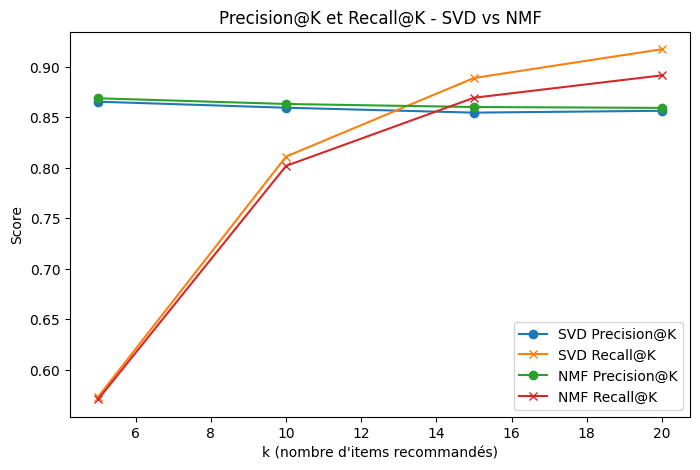

In [31]:
plt.figure(figsize=(8, 5))
for name in models:
    plt.plot(k_values, results[name]["Precision"], marker='o', label=f'{name} Precision@K')
    plt.plot(k_values, results[name]["Recall"], marker='x', label=f'{name} Recall@K')

plt.xlabel("k (nombre d'items recommandés)")
plt.ylabel("Score")
plt.title("Precision@K et Recall@K - SVD vs NMF")
plt.legend()
plt.show()

On remarque que les deux modèles ont des résultats assez similaires.  Cela veut donc dire qu'ils arrivent tous les deux à recommander la même quantité de livres pertinents. Regardons maintenant leur temps d'entrainement, notre dataset est assez court donc ce n'est pas spécialement important mais si on compte travailler sur de plus gros datasets, on aimerait avoir un modèle qui s'entraine et prédit rapidement.

In [264]:
import time
import numpy as np
from surprise import Dataset
from surprise.model_selection import KFold

def evaluate_model(model, data, k=5, model_name=""):
    kf = KFold(n_splits=k)
    start_time = time.time()
    
    for i, (trainset, testset) in enumerate(kf.split(data), start=1):
        fold_start = time.time()
        print(f"\n[{model_name}] Fold {i}/{k} - Entraînement...")
        
        model.fit(trainset)
        model.test(testset)
        
        fold_end = time.time()
        print(f"[{model_name}] Fold {i} terminé en {fold_end - fold_start:.2f} sec")

    end_time = time.time()
    total_time = end_time - start_time
    print(f"\n[{model_name}] Temps total : {total_time:.2f} sec")
    return total_time

# Chargement du dataset
data = Dataset.load_from_df(collaborative_df[['user_id', 'item_id', 'rating']], reader)

# Évaluation avec logs détaillés
time_svd = evaluate_model(svd, data, k=5, model_name="SVD")
time_nmf = evaluate_model(nmf, data, k=5, model_name="NMF")

print(f"\nRésumé final :\nSVD = {time_svd:.2f} sec\nNMF = {time_nmf:.2f} sec")



[SVD] Fold 1/5 - Entraînement...
[SVD] Fold 1 terminé en 0.41 sec

[SVD] Fold 2/5 - Entraînement...
[SVD] Fold 2 terminé en 0.42 sec

[SVD] Fold 3/5 - Entraînement...
[SVD] Fold 3 terminé en 0.36 sec

[SVD] Fold 4/5 - Entraînement...
[SVD] Fold 4 terminé en 0.33 sec

[SVD] Fold 5/5 - Entraînement...
[SVD] Fold 5 terminé en 0.28 sec

[SVD] Temps total : 1.96 sec

[NMF] Fold 1/5 - Entraînement...
[NMF] Fold 1 terminé en 9.46 sec

[NMF] Fold 2/5 - Entraînement...
[NMF] Fold 2 terminé en 11.72 sec

[NMF] Fold 3/5 - Entraînement...
[NMF] Fold 3 terminé en 9.65 sec

[NMF] Fold 4/5 - Entraînement...
[NMF] Fold 4 terminé en 9.75 sec

[NMF] Fold 5/5 - Entraînement...
[NMF] Fold 5 terminé en 9.66 sec

[NMF] Temps total : 50.37 sec

Résumé final :
SVD = 1.96 sec
NMF = 50.37 sec


La différence de temps n'est pas négligeable, NMF prendre près de dix fois le temps de SVD pour les mêmes opérations. Elle est peut-être due au nombre d'epochs ou de n_factors. Testons avec le même nombre pour voir si cela change quelque chose.

In [ ]:
# Même nombre d'epochs

epochs=50

svd = SVD(n_factors=10, lr_all=0.002, reg_all=0.02, n_epochs=epochs)
nmf = NMF(n_factors=150, n_epochs=epochs, reg_pu=0.12, reg_qi=0.06)

# Chargement du dataset
data = Dataset.load_from_df(collaborative_df[['user_id', 'item_id', 'rating']], reader)

# Évaluation avec logs détaillés
time_svd = evaluate_model(svd, data, k=5, model_name="SVD")
time_nmf = evaluate_model(nmf, data, k=5, model_name="NMF")

print(f"\nRésumé final :\nSVD = {time_svd:.2f} sec\nNMF = {time_nmf:.2f} sec")


[SVD] Fold 1/5 - Entraînement...
[SVD] Fold 1 terminé en 0.29 sec

[SVD] Fold 2/5 - Entraînement...
[SVD] Fold 2 terminé en 0.29 sec

[SVD] Fold 3/5 - Entraînement...
[SVD] Fold 3 terminé en 0.31 sec

[SVD] Fold 4/5 - Entraînement...
[SVD] Fold 4 terminé en 0.30 sec

[SVD] Fold 5/5 - Entraînement...
[SVD] Fold 5 terminé en 0.30 sec

[SVD] Temps total : 1.63 sec

[NMF] Fold 1/5 - Entraînement...
[NMF] Fold 1 terminé en 4.65 sec

[NMF] Fold 2/5 - Entraînement...
[NMF] Fold 2 terminé en 4.73 sec

[NMF] Fold 3/5 - Entraînement...
[NMF] Fold 3 terminé en 4.74 sec

[NMF] Fold 4/5 - Entraînement...
[NMF] Fold 4 terminé en 4.66 sec

[NMF] Fold 5/5 - Entraînement...
[NMF] Fold 5 terminé en 4.71 sec

[NMF] Temps total : 23.63 sec

Résumé final :
SVD = 1.63 sec
NMF = 23.63 sec


On dirait que ce n'est pas le nombre d'epochs le reponsable. Essayons maintenant avec le même nombre de n_factors.

In [269]:
# Même nombre de n_factors

n_factors=10

svd = SVD(n_factors=n_factors, lr_all=0.002, reg_all=0.02, n_epochs=50)
nmf = NMF(n_factors=n_factors, n_epochs=50, reg_pu=0.12, reg_qi=0.06)

# Chargement du dataset
data = Dataset.load_from_df(collaborative_df[['user_id', 'item_id', 'rating']], reader)

# Évaluation avec logs détaillés
time_svd = evaluate_model(svd, data, k=5, model_name="SVD")
time_nmf = evaluate_model(nmf, data, k=5, model_name="NMF")

print(f"\nRésumé final :\nSVD = {time_svd:.2f} sec\nNMF = {time_nmf:.2f} sec")


[SVD] Fold 1/5 - Entraînement...
[SVD] Fold 1 terminé en 0.28 sec

[SVD] Fold 2/5 - Entraînement...
[SVD] Fold 2 terminé en 0.32 sec

[SVD] Fold 3/5 - Entraînement...
[SVD] Fold 3 terminé en 0.33 sec

[SVD] Fold 4/5 - Entraînement...
[SVD] Fold 4 terminé en 0.30 sec

[SVD] Fold 5/5 - Entraînement...
[SVD] Fold 5 terminé en 0.34 sec

[SVD] Temps total : 2.10 sec

[NMF] Fold 1/5 - Entraînement...
[NMF] Fold 1 terminé en 0.68 sec

[NMF] Fold 2/5 - Entraînement...
[NMF] Fold 2 terminé en 0.65 sec

[NMF] Fold 3/5 - Entraînement...
[NMF] Fold 3 terminé en 0.68 sec

[NMF] Fold 4/5 - Entraînement...
[NMF] Fold 4 terminé en 0.67 sec

[NMF] Fold 5/5 - Entraînement...
[NMF] Fold 5 terminé en 0.68 sec

[NMF] Temps total : 3.50 sec

Résumé final :
SVD = 2.10 sec
NMF = 3.50 sec


C'était bien les n_factors qui influaient sur la vitesse de NMF, et c'est logique comme c'est la dimension des facteurs latents à calculer pour chaque utilisateur. Ceux de SVD n'étaient que de dimension 10. Maintenant, essayons avec un grand n_factors sur les deux modèles.

In [270]:
# Même nombre de n_factors

n_factors=150

svd = SVD(n_factors=n_factors, lr_all=0.002, reg_all=0.02, n_epochs=50)
nmf = NMF(n_factors=n_factors, n_epochs=50, reg_pu=0.12, reg_qi=0.06)

# Chargement du dataset
data = Dataset.load_from_df(collaborative_df[['user_id', 'item_id', 'rating']], reader)

# Évaluation avec logs détaillés
time_svd = evaluate_model(svd, data, k=5, model_name="SVD")
time_nmf = evaluate_model(nmf, data, k=5, model_name="NMF")

print(f"\nRésumé final :\nSVD = {time_svd:.2f} sec\nNMF = {time_nmf:.2f} sec")


[SVD] Fold 1/5 - Entraînement...
[SVD] Fold 1 terminé en 0.82 sec

[SVD] Fold 2/5 - Entraînement...
[SVD] Fold 2 terminé en 0.81 sec

[SVD] Fold 3/5 - Entraînement...
[SVD] Fold 3 terminé en 0.82 sec

[SVD] Fold 4/5 - Entraînement...
[SVD] Fold 4 terminé en 0.82 sec

[SVD] Fold 5/5 - Entraînement...
[SVD] Fold 5 terminé en 0.84 sec

[SVD] Temps total : 4.23 sec

[NMF] Fold 1/5 - Entraînement...
[NMF] Fold 1 terminé en 4.63 sec

[NMF] Fold 2/5 - Entraînement...
[NMF] Fold 2 terminé en 4.68 sec

[NMF] Fold 3/5 - Entraînement...
[NMF] Fold 3 terminé en 4.61 sec

[NMF] Fold 4/5 - Entraînement...
[NMF] Fold 4 terminé en 4.59 sec

[NMF] Fold 5/5 - Entraînement...
[NMF] Fold 5 terminé en 4.62 sec

[NMF] Temps total : 23.26 sec

Résumé final :
SVD = 4.23 sec
NMF = 23.26 sec


Pour un même grand nombre NMF est cinq fois plus lent. On privilégiera donc SVD pour le modèle collaboratif.